In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot
from matplotlib.colors import Normalize

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [3]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'O_1s_(2)' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685, 'Cl_2s' : 0.37,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69}

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}

## Quick check acn microscopy

In [115]:
path = '/Users/pabloherrero/sabat/LabFBIp/copy/data/solutionLaser/15102021/AcN_OB.csv'
df = pd.read_csv(path, header=None)
pd.DataFrame(df.mean().values.reshape(6,5).T)

0             1             2             3            4  \
0   61545.5  1.319541e+06  3.835820e+06  2.407560e+06     425180.0   
1  -20394.1  6.950130e+07  1.981510e+08  1.221370e+08   26473600.0   
2  187425.3  3.283080e+08  9.179080e+08  5.678560e+08  119595000.0   
3  363031.0  6.964390e+08  1.920080e+09  1.177210e+09  257896000.0   
4  482233.1  1.041180e+09  2.875420e+09  1.726970e+09  391441000.0   

             5  
0     652041.0  
1   33765300.0  
2  155370000.0  
3  343030000.0  
4  518254000.0

In [98]:
path = '/Users/pabloherrero/sabat/LabFBIp/copy/data/solutionLaser/15102021/AcN_OB_media.csv'
dfavg = pd.read_csv(path, header=None, index_col=None, names=['filter_'+str(i) for i in range(1,7)])
dfavg

filter_1      filter_2      filter_3      filter_4     filter_5  \
0   61545.0  1.319500e+06  3.835800e+06  2.407600e+06     425180.0   
1  -20393.0  6.950100e+07  1.981500e+08  1.221400e+08   26474000.0   
2  187420.0  3.283100e+08  9.179100e+08  5.678600e+08  119590000.0   
3  363030.0  6.964400e+08  1.920100e+09  1.177200e+09  257900000.0   
4  482230.0  1.041200e+09  2.875400e+09  1.727000e+09  391440000.0   

      filter_6  
0     652040.0  
1   33765000.0  
2  155370000.0  
3  343030000.0  
4  518250000.0

In [116]:
df

0         1         2         3         4          5           6   \
0  137600.0  -33830.0   39163.0  355450.0  -76679.0  1330900.0  69424000.0   
1  126280.0   49287.0  242850.0  364490.0  691920.0  1378700.0  69437000.0   
2   14676.0   45817.0  150940.0  265540.0  583700.0  1398800.0  69633000.0   
3   71096.0 -128550.0  369840.0  194230.0  517020.0  1490900.0  69605000.0   
4  105360.0  -38998.0  303500.0  353990.0  599510.0   991710.0  69282000.0   
5  -37772.0  154860.0  133470.0  490510.0  361660.0  1438300.0  69120000.0   
6  276420.0  -18465.0  250440.0  471200.0  508050.0  1329100.0  69388000.0   
7   36485.0 -192430.0  251290.0  280300.0  583630.0  1255900.0  69476000.0   
8 -243180.0   43334.0  -34100.0  355600.0  571660.0  1253000.0  69738000.0   
9  128490.0  -84966.0  166860.0  499000.0  481860.0  1328100.0  69910000.0   

            7            8             9   ...        20          21  \
0  329220000.0  695270000.0  1.042800e+09  ...  507790.0  26806000.0   
1  328010000.0  698170000.0  1.042500e+09  ...  528140.0  26468000.0   
2  328100000.0  695810000.0  1.039900e+09  ...  642990.0  26248000.0   
3  328400000.0  698020000.0  1.041800e+09  ...  302870.0  26612000.0   
4  327600000.0  696290000.0  1.039400e+09  ...  585190.0  26325000.0   
5  328990000.0  697960000.0  1.039200e+09  ...  229240.0  26084000.0   
6  327880000.0  694600000.0  1.043000e+09  ...  227230.0  26849000.0   
7  329280000.0  697540000.0  1.041800e+09  ...  303560.0  26705000.0   
8  328670000.0  695170000.0  1.041100e+09  ...  630420.0  26212000.0   
9  326930000.0  695560000.0  1.040300e+09  ...  294370.0  26427000.0   

            22           23           24        25          26           27  \
0  119120000.0  257400000.0  392060000.0  388330.0  33874000.0  155640000.0   
1  119380000.0  257200000.0  392180000.0  763510.0  34023000.0  155590000.0   
2  119880000.0  259000000.0  390530000.0  436760.0  33760000.0  155630000.0   
3  120050000.0  257230000.0  390810000.0  565200.0  33667000.0  156070000.0   
4  120020000.0  258090000.0  392630000.0  737980.0  33543000.0  155530000.0   
5  119460000.0  257630000.0  391690000.0  439500.0  33768000.0  154920000.0   
6  119230000.0  257760000.0  392270000.0  715800.0  33651000.0  155120000.0   
7  119850000.0  258340000.0  391420000.0  789140.0  33691000.0  155610000.0   
8  119420000.0  257870000.0  389840000.0  860890.0  33970000.0  154810000.0   
9  119540000.0  258440000.0  390980000.0  823300.0  33706000.0  154780000.0   

            28           29  
0  344640000.0  517760000.0  
1  342790000.0  517790000.0  
2  343390000.0  518050000.0  
3  342860000.0  519210000.0  
4  342400000.0  518540000.0  
5  343380000.0  518720000.0  
6  343070000.0  517530000.0  
7  342170000.0  518080000.0  
8  343790000.0  517960000.0  
9  341810000.0  518900000.0  

[10 rows x 30 columns]

In [108]:
path = '/Users/pabloherrero/sabat/LabFBIp/copy/data/solutionLaser/15102021/AcN_power.csv'
dfpow = pd.read_csv(path, header=None)
dfpow

0         1         2         3         4         5         6   \
0  0.000022  0.000021  0.000021  0.000021  0.000021  0.000021  0.000020   
1  0.000535  0.000537  0.000537  0.000537  0.000539  0.000539  0.000538   
2  0.002354  0.002355  0.002357  0.002354  0.002354  0.002350  0.002358   
3  0.004934  0.004932  0.004940  0.004932  0.004929  0.004934  0.004934   
4  0.007359  0.007352  0.007363  0.007363  0.007363  0.007347  0.007352   

         7         8         9   ...        50        51        52        53  \
0  0.000021  0.000021  0.000021  ...  0.000022  0.000021  0.000020  0.000020   
1  0.000539  0.000539  0.000538  ...  0.000541  0.000542  0.000542  0.000542   
2  0.002356  0.002354  0.002361  ...  0.002360  0.002359  0.002367  0.002369   
3  0.004931  0.004940  0.004931  ...  0.004926  0.004935  0.004935  0.004935   
4  0.007365  0.007356  0.007347  ...  0.007371  0.007372  0.007374  0.007386   

         54        55        56        57        58        59  
0  0.000020  0.000021  0.000021  0.000020  0.000020  0.000020  
1  0.000540  0.000541  0.000542  0.000543  0.000544  0.000544  
2  0.002362  0.002358  0.002364  0.002361  0.002361  0.002358  
3  0.004928  0.004939  0.004933  0.004929  0.004940  0.004932  
4  0.007372  0.007376  0.007379  0.007372  0.007387  0.007390  

[5 rows x 60 columns]

Text(0.5, 0, 'Power [µW]')

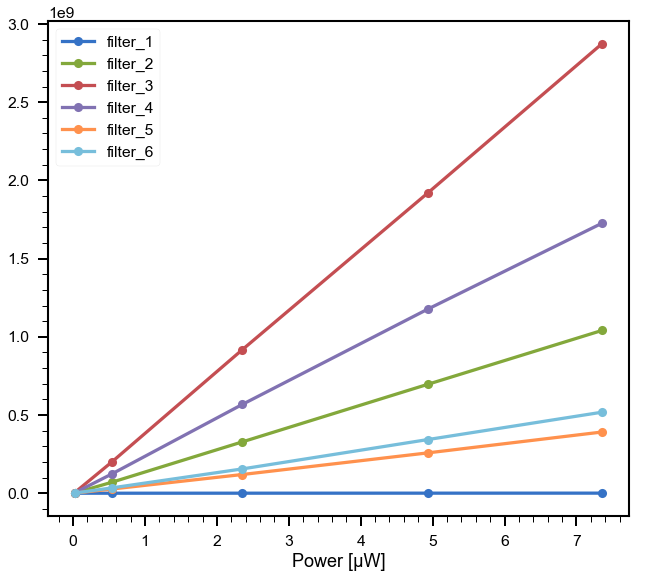

In [111]:
for c in dfavg:
    plt.plot(dfpow.iloc[:, 0]*1000, dfavg[c], 'o-', label=c)
plt.legend()
plt.xlabel('Power [µW]')

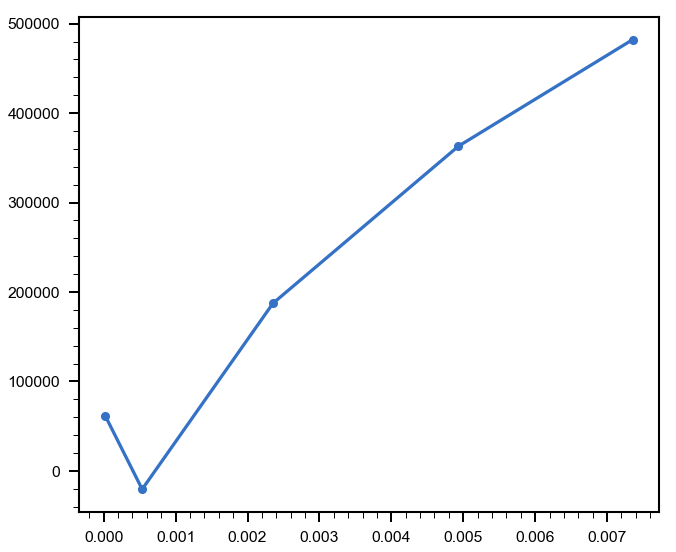

In [114]:
plt.plot(x, y, 'o-')

In [112]:
x = dfpow.iloc[:,0]
y = dfavg['filter_1']
m,b = np.polyfit(x, y, 1)
m, b

(65789682.59488049, 14730.843748042043)

Text(0, 0.5, 'Total counts [A.U.]')

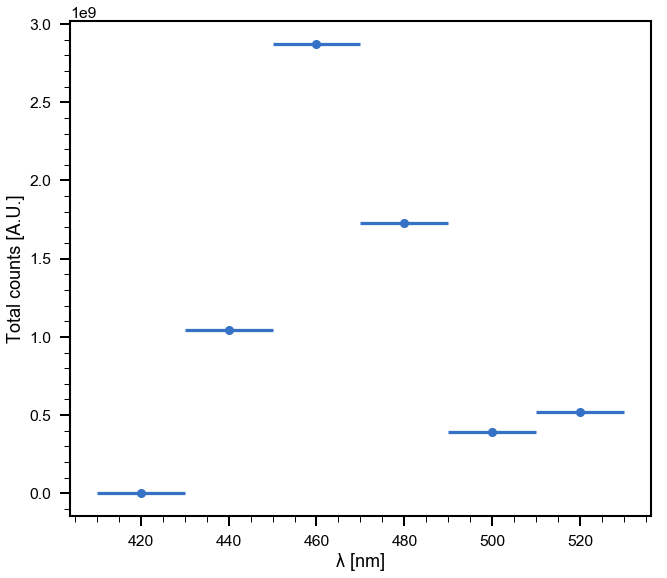

In [229]:
fil = [420, 440, 460, 480, 500, 520]
i_fil = dfavg.iloc[4,:]
plt.errorbar(fil, i_fil, xerr=10, fmt='o')
plt.xlabel('λ [nm]')
plt.ylabel('Total counts [A.U.]')

# Import data G3

In [4]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/'
files = glob.glob(path+'/**/**/*.uxy')
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_FBIG3_subl_10min_3.2A.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211011_AuMica_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211013_AuMica_FBIG3_subl_30min_3.5A.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_FBIG3_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_FBIG3_subl_15min_BaCl2_1min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/20211018_AuMica_FBIG3_subl_27min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/2021101

In [5]:
unscaled = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_FBIG3_subl_10min_3.2A.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211011_AuMica_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211013_AuMica_FBIG3_subl_30min_3.5A.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_FBIG3_subl_15min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc

In [6]:
unscaled[11], unscaled[12] = unscaled[12], unscaled[11]
unscaled[7], unscaled[8] = unscaled[8], unscaled[7]

In [7]:
[xp.name for xp in unscaled[7:]]

['AuMica_clean',
 'AuMica_FBIG3_subl_27min',
 'AuMica_FBIG3_subl_27min_BaCl2_30s',
 'AuMica_FBIG3_subl_27min_BaCl2_60s',
 'AuMica_FBIG3_subl_27min_BaCl2_80s',
 'AuMica_FBIG3_subl_27min_BaCl2_100s',
 'AuMica_FBIG3_subl_27min_BaCl2_130s',
 'AuMica_FBIG3_subl_27min_BaCl2_160s']

## Subtract bg from FBIG3_subl_27min (sparky)

In [143]:
file = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211020_AuMica_FBIG3_subl_27min_BaCl2_100s.fxy'
sparky = read_processed_xp(file)

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211020_AuMica_FBIG3_subl_27min_BaCl2_100s.fxy.ft', returning empty fit dict


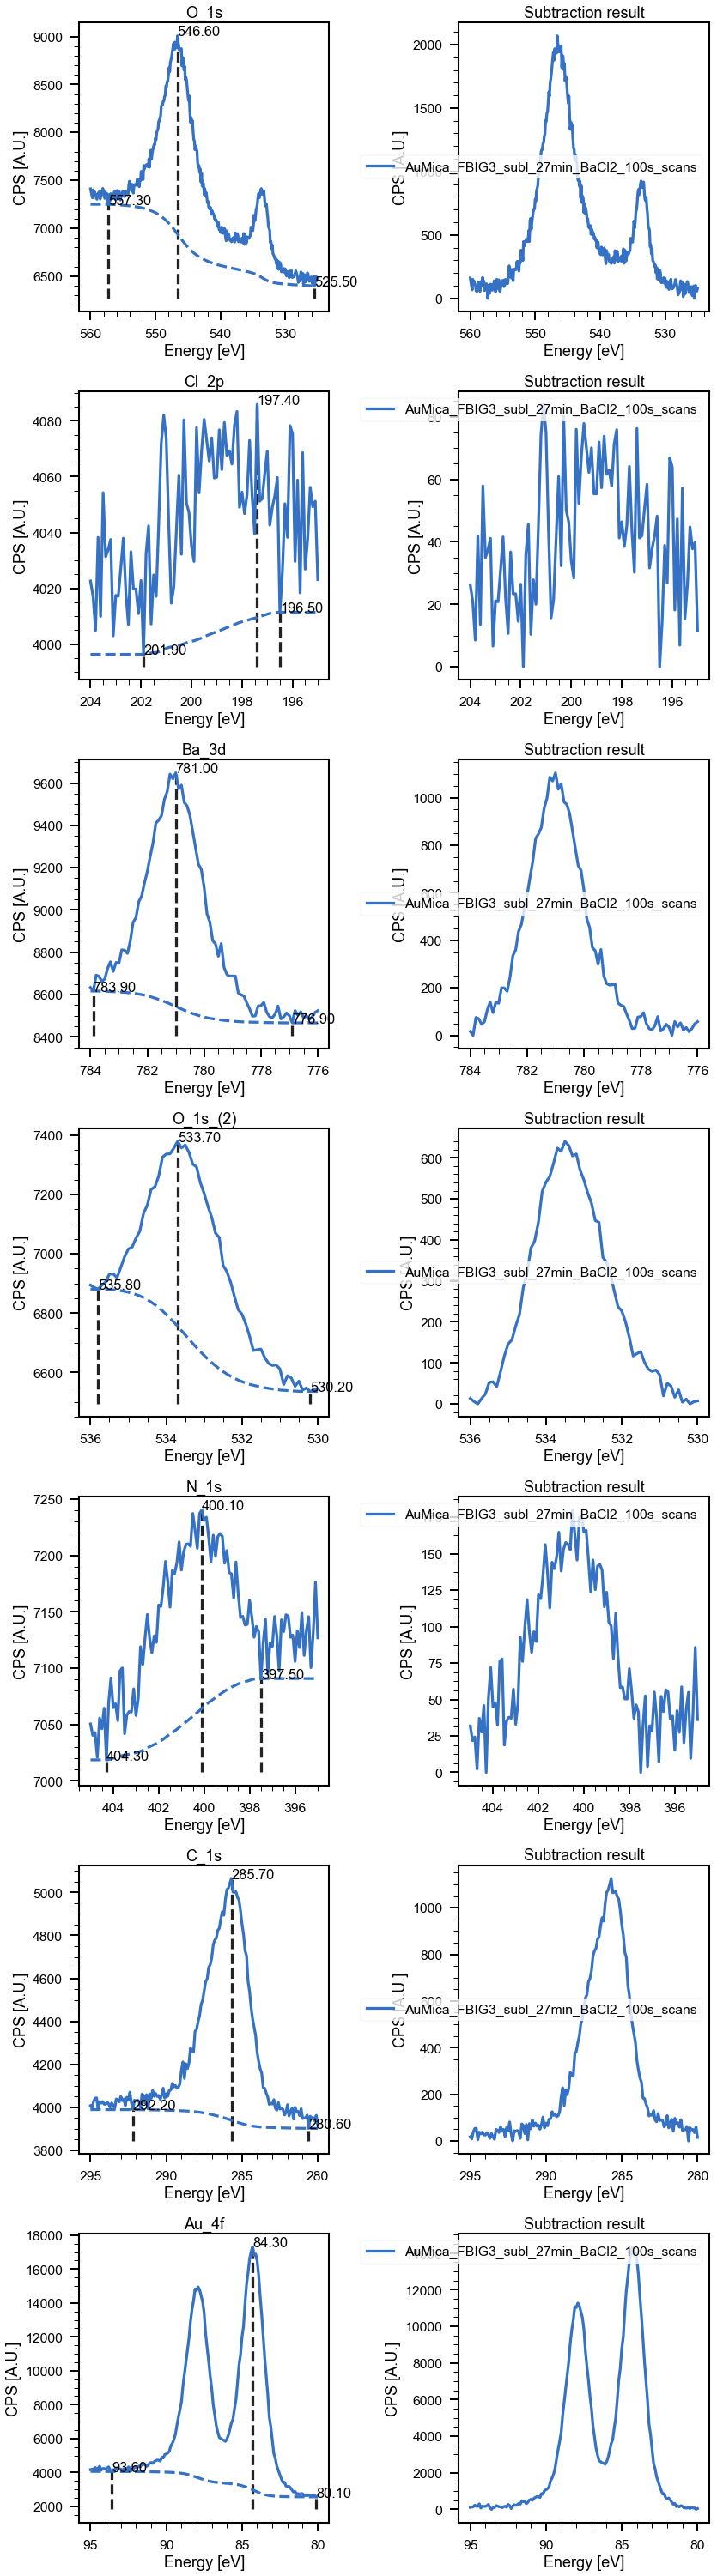

In [37]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s', 'Au_4f']
sparky = bulk_bg_subtract([sparky], regs)[0]

In [39]:
write_processed_xp(sparky.path., sparky)

In [38]:
sparky.name = sparky.name.replace('_scans', '')

## Plot regions

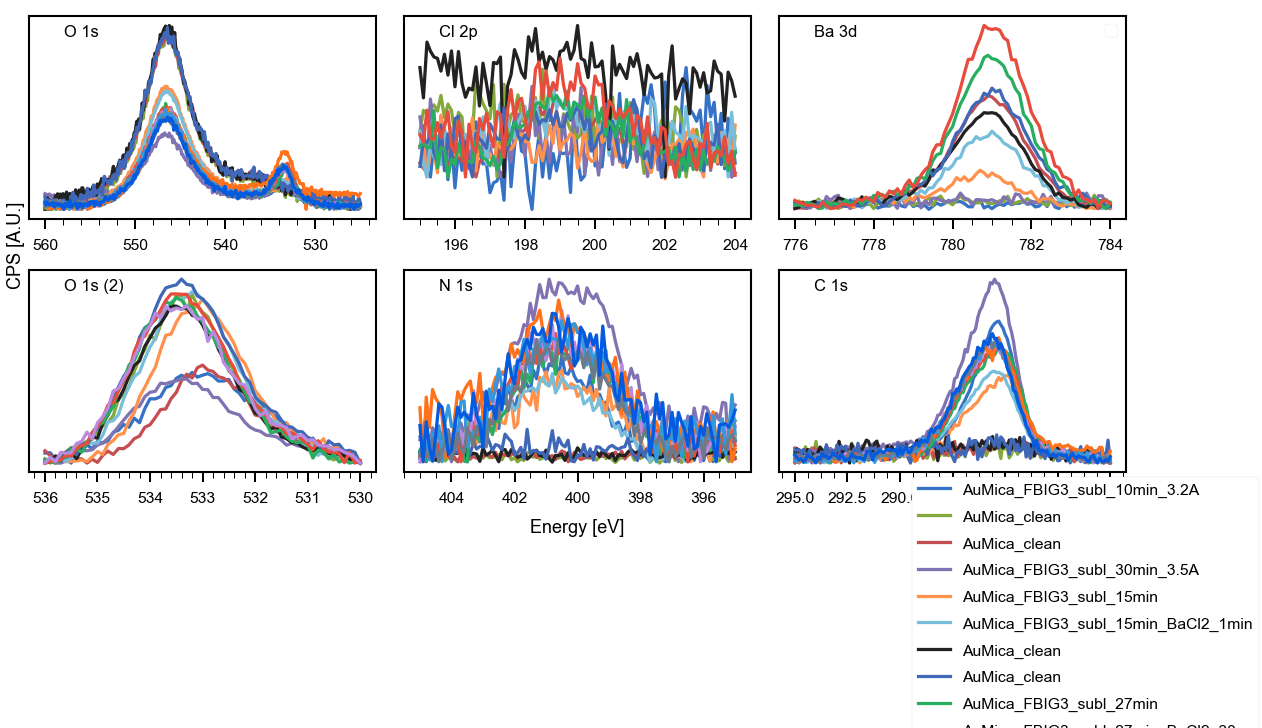

In [8]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s']
plot_xp_regions(unscaled, regs);

# Stoichiometry

'Cl_2p' region does not exist in AuMica_clean
'Cl_2p' region does not exist in AuMica_clean
'Cl_2p' region does not exist in AuMica_FBIG3_subl_30min_3.5A
'Cl_2p' region does not exist in AuMica_clean
'Cl_2p' region does not exist in AuMica_clean
'Ba_3d' region does not exist in AuMica_clean
'Ba_3d' region does not exist in AuMica_clean
'Ba_3d' region does not exist in AuMica_FBIG3_subl_30min_3.5A
'Ba_3d' region does not exist in AuMica_clean
'Ba_3d' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean


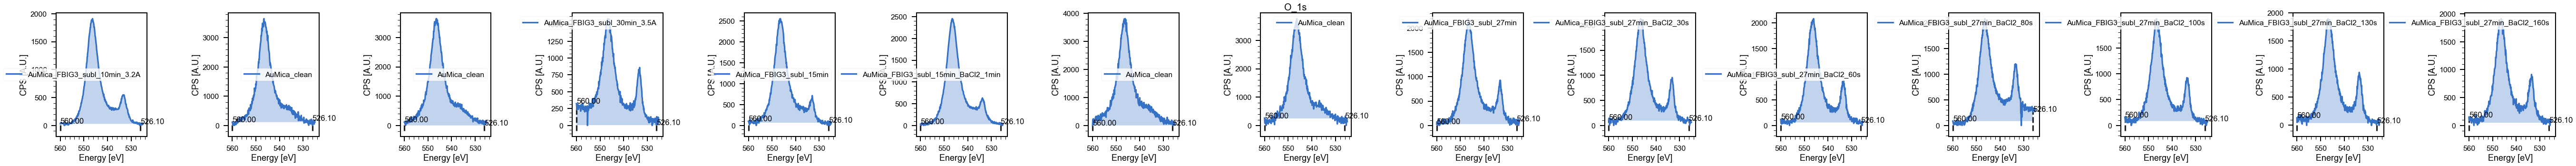

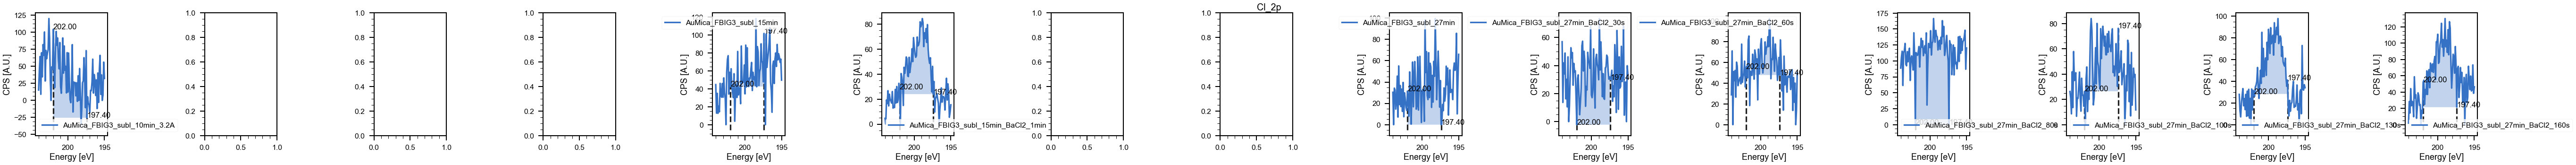

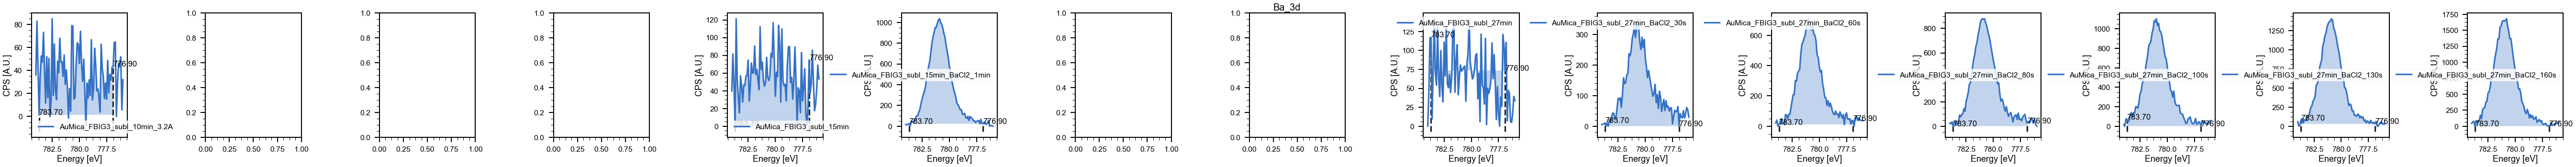

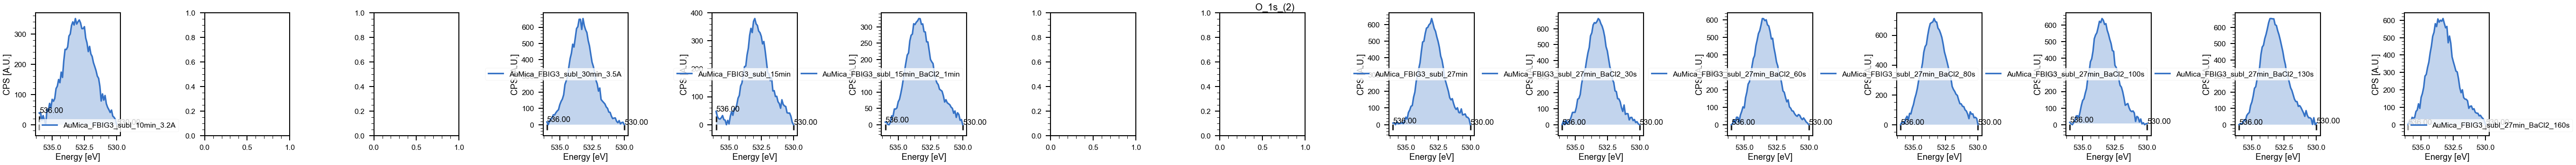

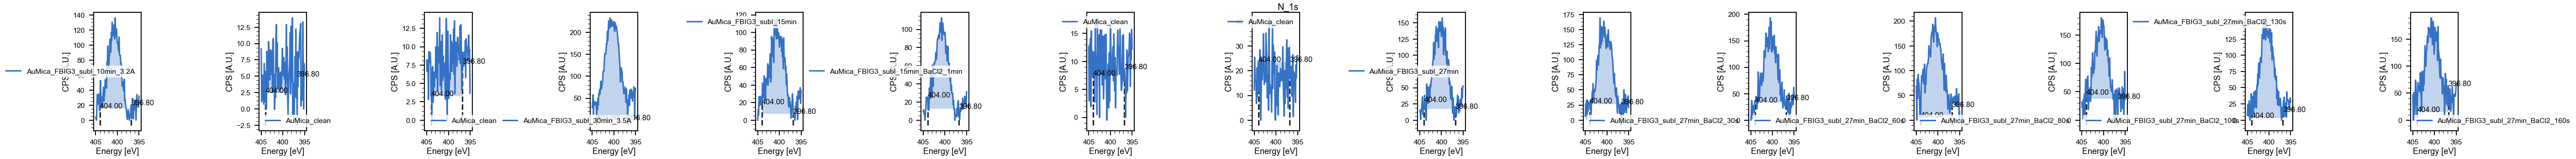

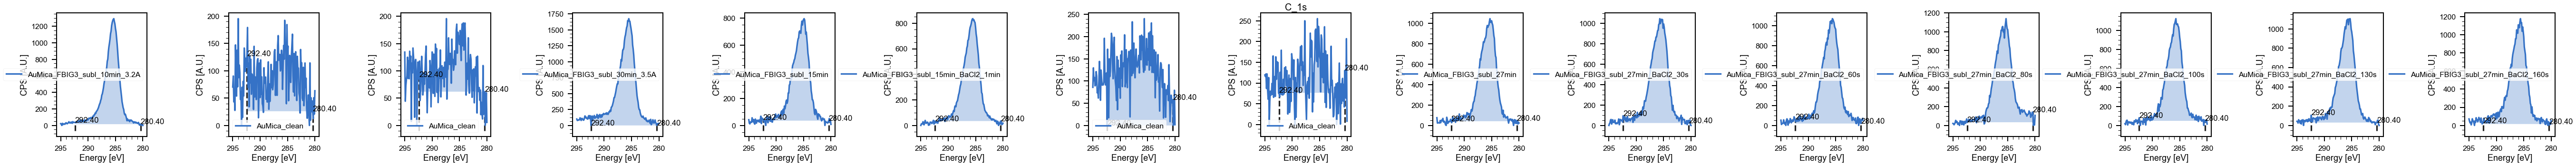

In [9]:
for r in regs:
    integrateRegions(unscaled, r, asf=asf)

In [10]:
[xp.name for xp in unscaled]

['AuMica_FBIG3_subl_10min_3.2A',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_30min_3.5A',
 'AuMica_FBIG3_subl_15min',
 'AuMica_FBIG3_subl_15min_BaCl2_1min',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_27min',
 'AuMica_FBIG3_subl_27min_BaCl2_30s',
 'AuMica_FBIG3_subl_27min_BaCl2_60s',
 'AuMica_FBIG3_subl_27min_BaCl2_80s',
 'AuMica_FBIG3_subl_27min_BaCl2_100s',
 'AuMica_FBIG3_subl_27min_BaCl2_130s',
 'AuMica_FBIG3_subl_27min_BaCl2_160s']

In [11]:
ag3sto = {'C_1s': 38, 'O_1s_(2)':5, 'N_1s':3, 'Ba_3d': 1e-10, 'Cl_2p':1e-10}
g3sto = XPS_experiment(name='Stoichiometry FBI-G3', area=ag3sto)

g3 = [unscaled[i] for i in [0, 3, 4, 7]]
g3ba = [unscaled[j] for j in [5, 9, 10, 11, 12, 13, 14]]
g3ba[-1].area['N_1s'] = g3ba[-3].area['N_1s']
for xp in g3ba:
    xp.area['FBI-G3'] = xp.area['N_1s']/3

num = ['C_1s', 'C_1s', 'O_1s_(2)', 'Ba_3d', 'Cl_2p']
denom = ['O_1s_(2)', 'N_1s', 'N_1s', 'N_1s', 'Ba_3d']
display_stoichiometry(g3 + [g3sto], num, denom)
display_stoichiometry(g3ba, num + ['Ba_3d'], denom + ['FBI-G3'])

In [12]:
g3ba[0].area['Ba_3d']

329.65707161002877

# Coverage

In [13]:
inds = [[0, 1], [3, 2], [4, 6], [7,8]]
arrange_coverages(unscaled, inds, r_ml=1.1, region='Au_4f', mfp=3.8, takeoff=10)

matrix([[ 1.43923266,  0.01960179],
        [ 2.20708944,  0.02084436],
        [ 0.86386016,  0.00464483],
        [-1.65931107, -0.00919412]])

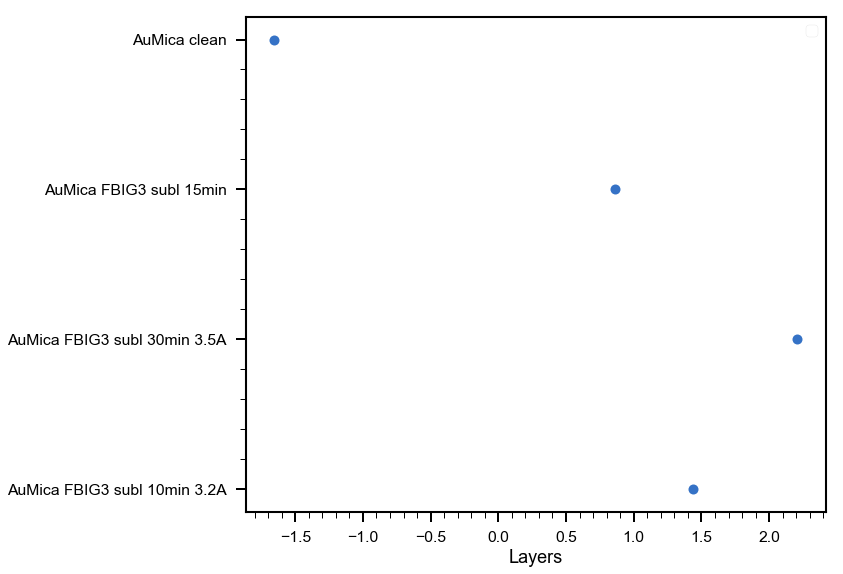

In [14]:
plot_coverages(g3)

# Compare all scaled G3 measurements

In [186]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/'
files = glob.glob(path+'/**/**/*.sxy')
files.sort()
fnew = []
for f in files:
    if ('clean' not in f) and ('BaCl2' not in f): fnew.append(f)
files = fnew
files

['/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_FBIG3_subl_10min_3.2A.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211013_AuMica_FBIG3_subl_30min_3.5A.sxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_FBIG3_subl_15min.sxy']

In [209]:
scaled = [read_processed_xp(f) for f in files]
names = [1.44, 2.2, 0.86]
for xp, n in zip(scaled, names):
    xp.name = 'FBI-G3, %.2f ML'%n
pivot = scaled[-1]
scaled[1:] = scaled[:-1]
scaled[0] = pivot
[xp.name for xp in scaled]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/proc/20211007_AuMica_FBIG3_subl_10min_3.2A.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/proc/20211013_AuMica_FBIG3_subl_30min_3.5A.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/proc/20211015_AuMica_FBIG3_subl_15min.sxy.ft', returning empty fit dict


['FBI-G3, 0.86 ML', 'FBI-G3, 1.44 ML', 'FBI-G3, 2.20 ML']

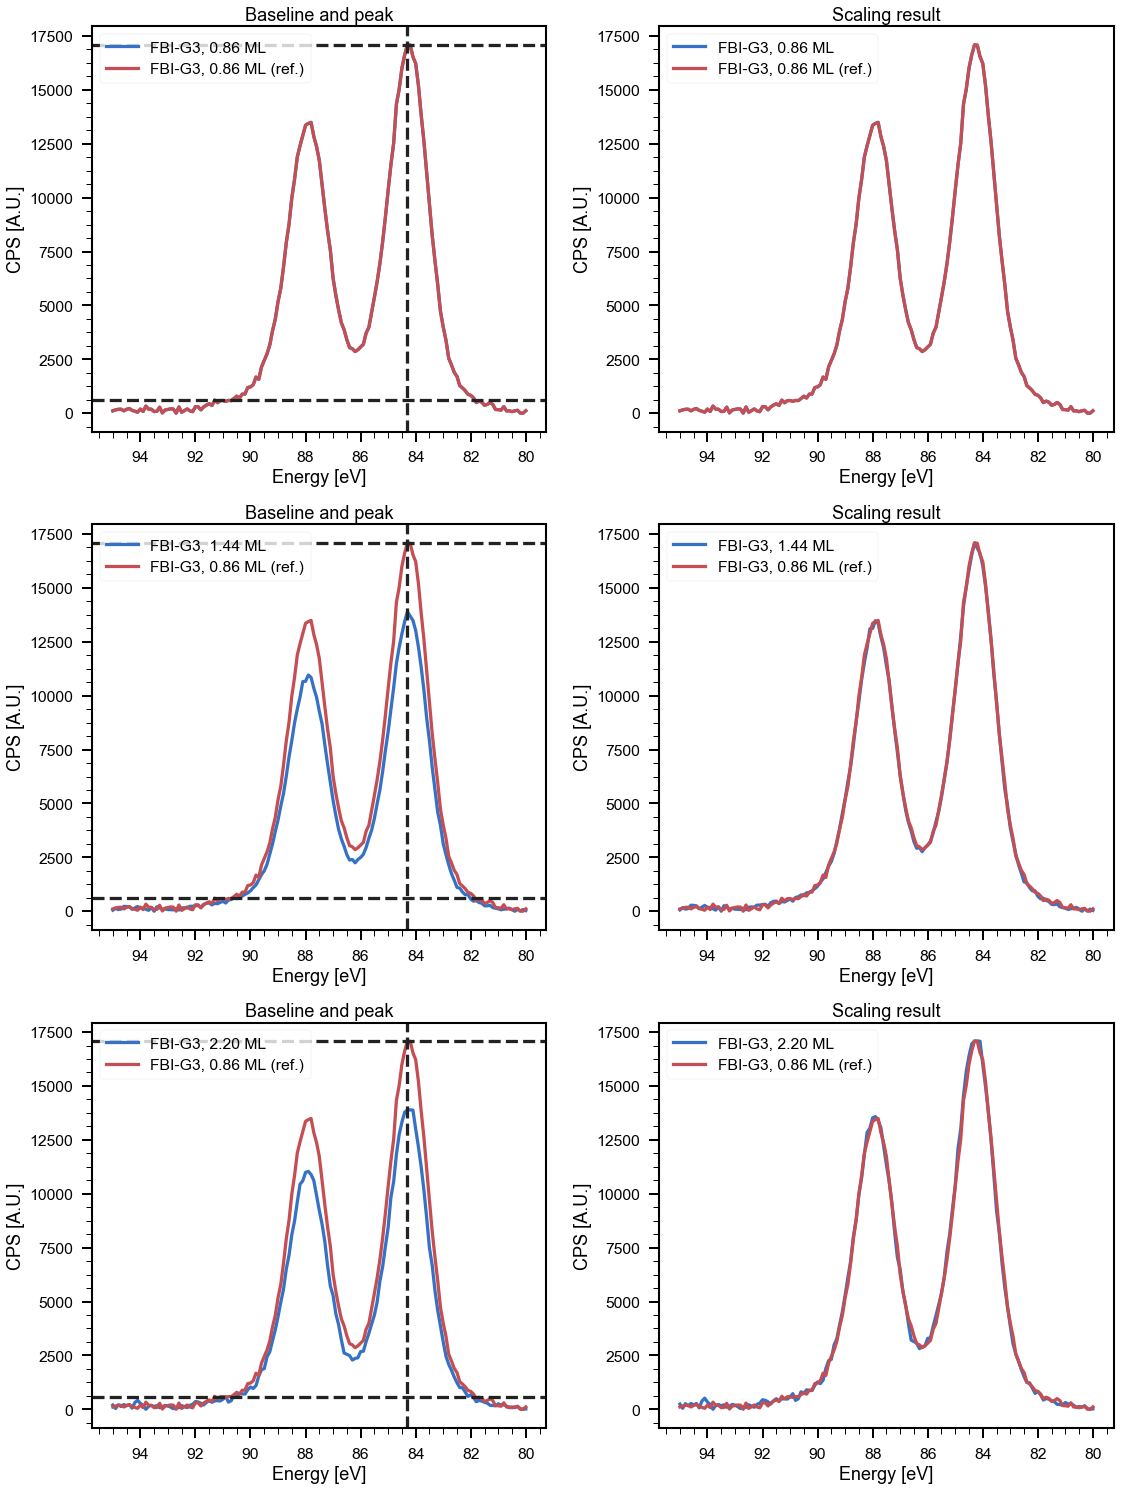

In [210]:
scaled = scale_and_plot_spectra(scaled, region='Au_4f')

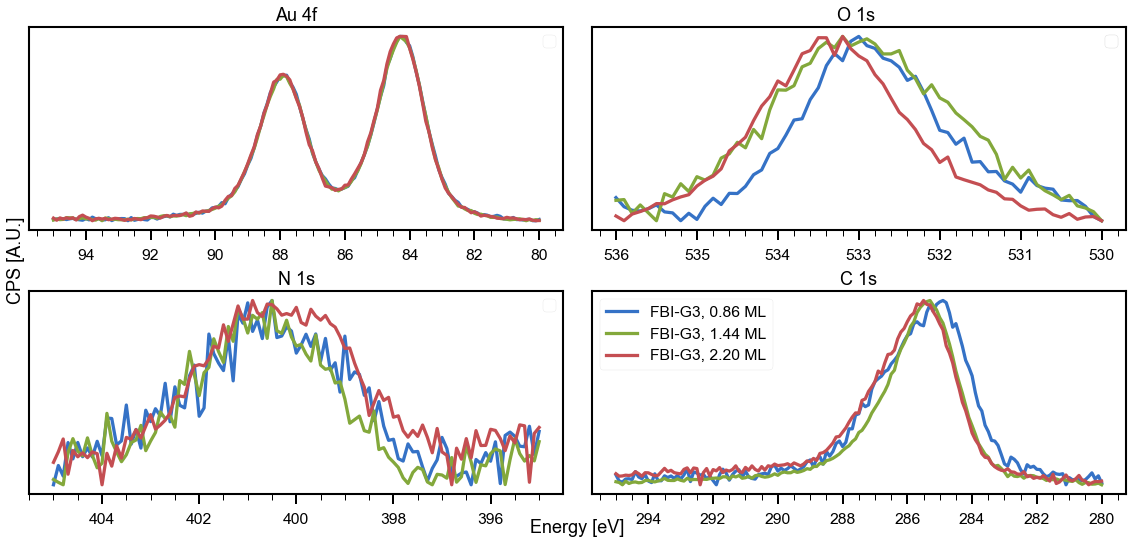

In [218]:
regs2 = ['Au_4f', 'O_1s_(2)', 'N_1s', 'C_1s']
ax = plot_normal_regions(scaled, regs2, ncols=2);
for a in ax:
    for aa in a:
        aa.set(title=aa.get_title().replace('_', ' ').replace('(2)', ''))

# Compare to FBI-G1

In [150]:
fileg1 = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min.uxy'
g1 = read_processed_xp(fileg1)

crop_spectrum(g1, 'O_1s', eup=536, edw=530, inplace=True);


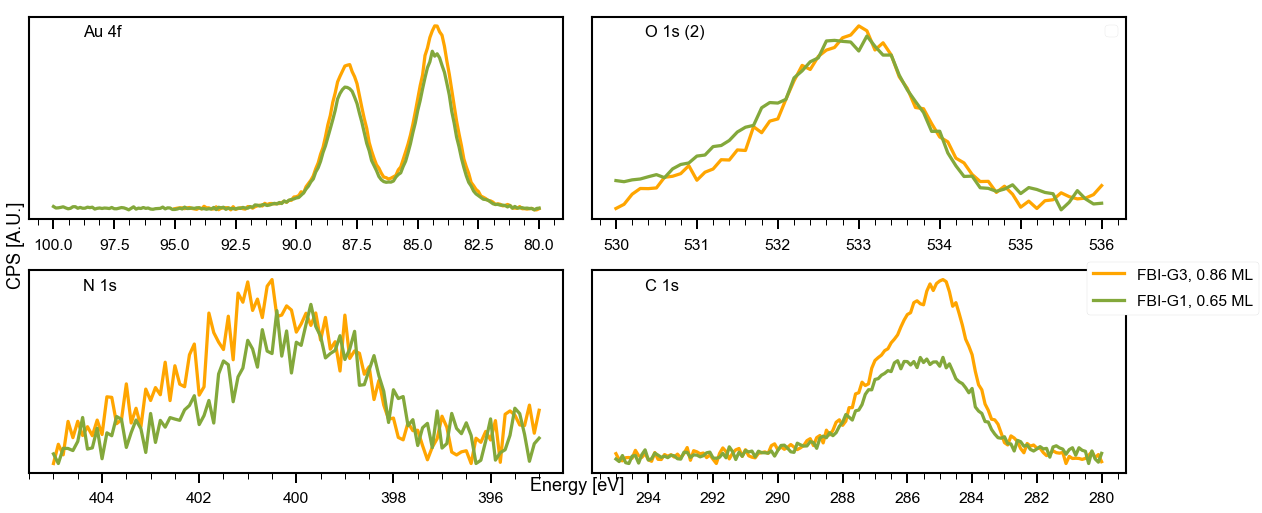

In [223]:
g3[2].color = 'orange'
g3[2].name = 'FBI-G3, 0.86 ML'
g1.name = 'FBI-G1, 0.65 ML'

regs2 = ['Au_4f', 'O_1s_(2)', 'N_1s', 'C_1s']
ax = plot_xp_regions([g3[2], g1], regs2, ncols=2);
plot_region(g1, 'O_1s', ax= ax[0, 1])

# Plot raw compare w/ and w/out Ba++

In [19]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/**'
files = glob.glob(path+'/*.xy')
files.sort()
files
fixedfiles = glob.glob(path+'/*.fxy')
files, fixedfiles


(['/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/20211007_AuMica_FBIG3_subl_10min_3.2A.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_07_AuMica/20211007_AuMica_clean.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/20211011_AuMica_clean.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_11_AuMica/20211013_AuMica_FBIG3_subl_30min_3.5A.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/20211015_AuMica_FBIG3_subl_15min.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/20211015_AuMica_FBIG3_subl_15min_BaCl2_1min.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_15_AuMica/20211015_AuMica_clean.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211018_AuMica_clean.xy',
  '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211019_AuMica_FBIG3_subl_27min_BaCl2_30s.xy',
  '/Users/pabl

In [20]:
raw3 = [xps_data_import(f) for f in files]
for f in fixedfiles:
    raw3.append(read_processed_xp(f))

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211020_AuMica_FBIG3_subl_27min_BaCl2_100s.fxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211018_AuMica_FBIG3_subl_27min.fxy.ft', returning empty fit dict


In [21]:
[xp.name for xp in raw3]

['AuMica_FBIG3_subl_10min_3.2A',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_30min_3.5A',
 'AuMica_FBIG3_subl_15min',
 'AuMica_FBIG3_subl_15min_BaCl2_1min',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_27min_BaCl2_30s',
 'AuMica_FBIG3_subl_27min_BaCl2_60s',
 'AuMica_FBIG3_subl_27min_BaCl2_80s',
 'AuMica_FBIG3_subl_27min_BaCl2_130s',
 'AuMica_FBIG3_subl_27min_BaCl2_160s',
 'AuMica_FBIG3_subl_27min_BaCl2_100s_scans',
 'AuMica_FBIG3_subl_27min_scans']

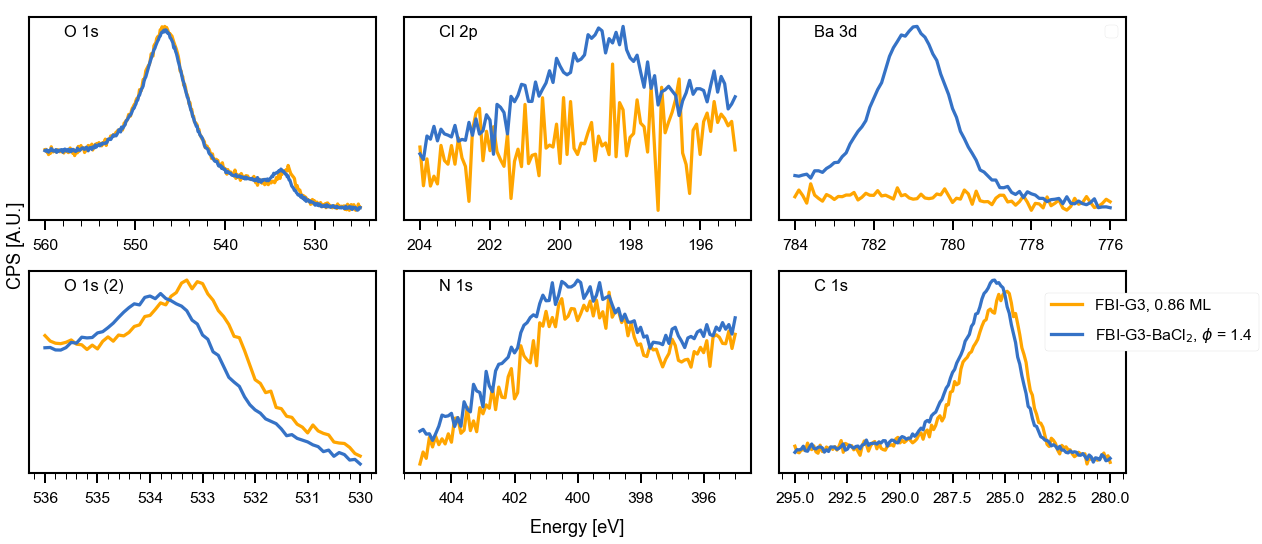

In [10]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s']

raw3[4].name = 'FBI-G3, 0.86 ML'
raw3[5].name = 'FBI-G3-BaCl$_2$, $\phi$ = 1.4'
raw3[4].color = 'orange'
raw3[5].color = 'b'

ax = plot_xp_regions(raw3[4:6] , regs, ncols=3);


### Energy shifts

In [16]:
def get_shift_ymax(xp: XPS_experiment, xp0: XPS_experiment, region):
    """Returns 2-tuple with the local maxima and the energy shift between them"""
    idxmax = np.argmax(xp.dfx[region].dropna().counts.values)
    locmax = xp.dfx[region].energy.iloc[idxmax]

    idxmax0 = np.argmax(xp0.dfx[region].dropna().counts.values)
    locmax0 = xp0.dfx[region].energy.iloc[idxmax0]
    return locmax - locmax0, (locmax, locmax0)

In [17]:
def get_shift_fit(xp: XPS_experiment, xp0: XPS_experiment, region):
    """Fit to one component and return centers of two components and the energy shift"""
    c1 = xp.fit[region].best_values['v1_center']
    c2 = xp0.fit[region].best_values['v1_center']
    
    return c1 - c2, (c1, c2)

(0.5, (533.8, 533.3))


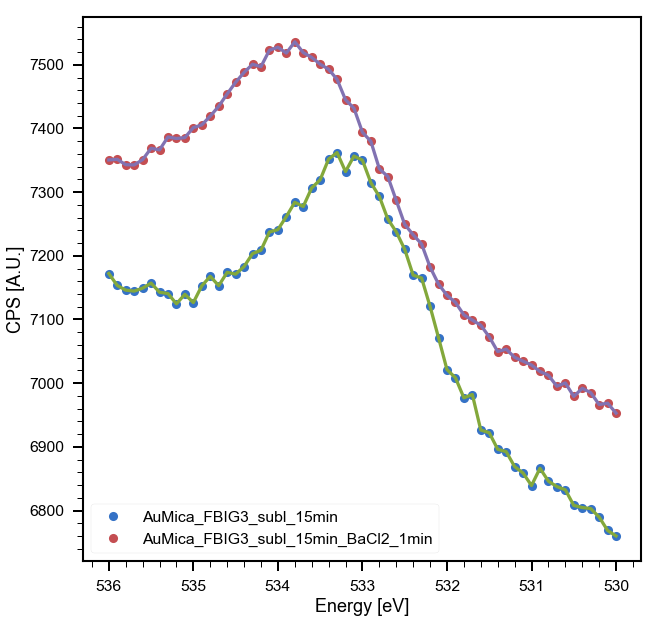

In [22]:
region = 'O_1s_(2)'
plt.figure(figsize=(10,10))
off = [0, 220, 220, 300, 500, 650]

for i,xp in enumerate(raw3[4:6]):
    scatter_region(xp, region, offset=off[i])
    plot_region(xp, region, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()
print(get_shift_ymax(raw3[5], raw3[4], region))

(0.6000000000000227, (285.5, 284.9))


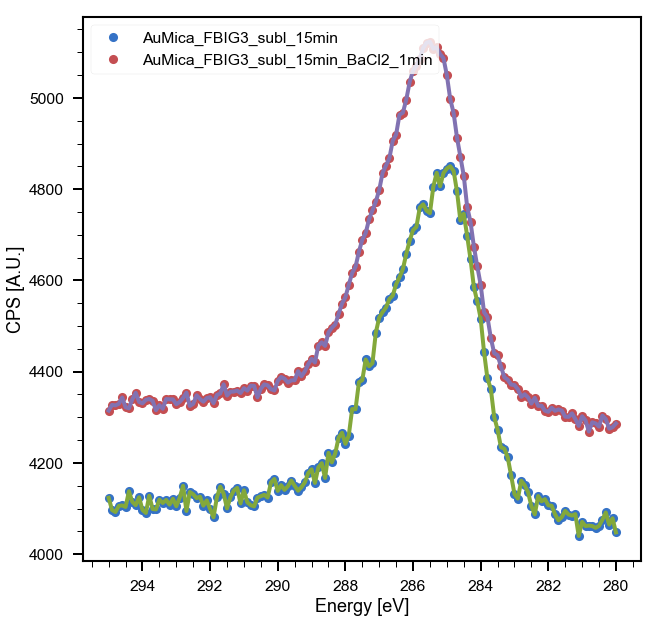

In [23]:
region = 'C_1s'
plt.figure(figsize=(10,10))
off = [0, 220, 220, 300, 500, 650]

for i,xp in enumerate(raw3[4:6]):
    scatter_region(xp, region, offset=off[i])
    plot_region(xp, region, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()
print(get_shift_ymax(raw3[5], raw3[4], region))

(0.4653560720632868, (533.337882893476, 532.8725268214127))


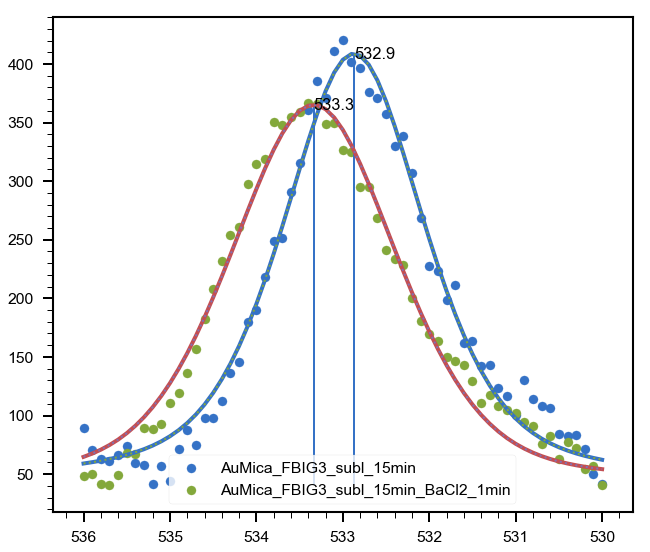

In [25]:
region = 'O_1s_(2)'
for xp in [unscaled[4], unscaled[5]]:
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=False)
    
plt.gca().invert_xaxis()
plt.legend()
print(get_shift_fit(unscaled[5], unscaled[4], region))

(0.5117713810781197, (285.2427951993881, 284.73102381831))


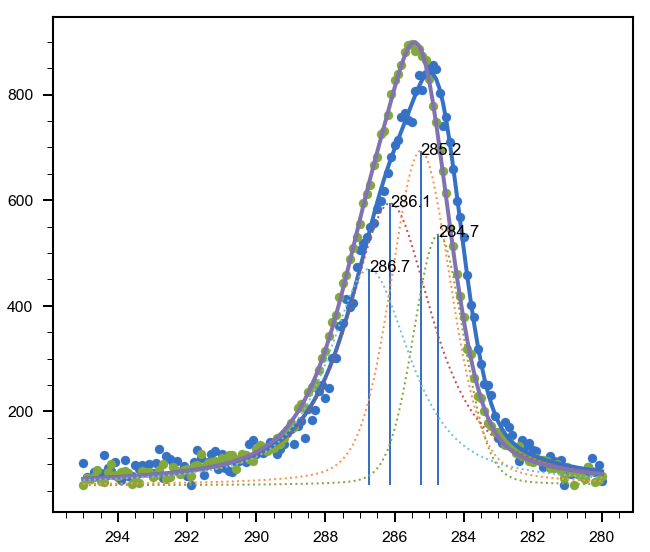

In [27]:
region = 'C_1s'
for xp in [unscaled[4], unscaled[5]]:
    xf0 = XPFit(xp, region)
#     xf0.preset_pars('v1_center',284.8)
    xf0.double_voigt(286)
    plot_fit_result(xp, region, plot_bg=False)
    
plt.gca().invert_xaxis()
print(get_shift_fit(unscaled[5], unscaled[4], region))

In [ ]:
unscaled[4].color=

(0.2523690170648365, (400.8028470698226, 400.55047805275774))


<Figure size 720x720 with 0 Axes>

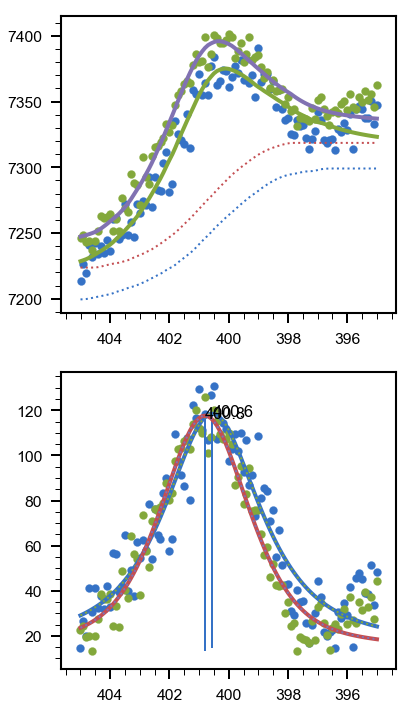

In [265]:
region = 'N_1s'
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
for xp in unscaled[4:6]:
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=True, ax=ax[0], plot_comps=False)
    plot_fit_result(xp, region, plot_bg=False, ax=ax[1])
    
plt.rcParams['lines.linewidth'] = 4
for a in ax:
    a.invert_xaxis()
print(get_shift_fit(unscaled[5], unscaled[4], region))

### O 1s

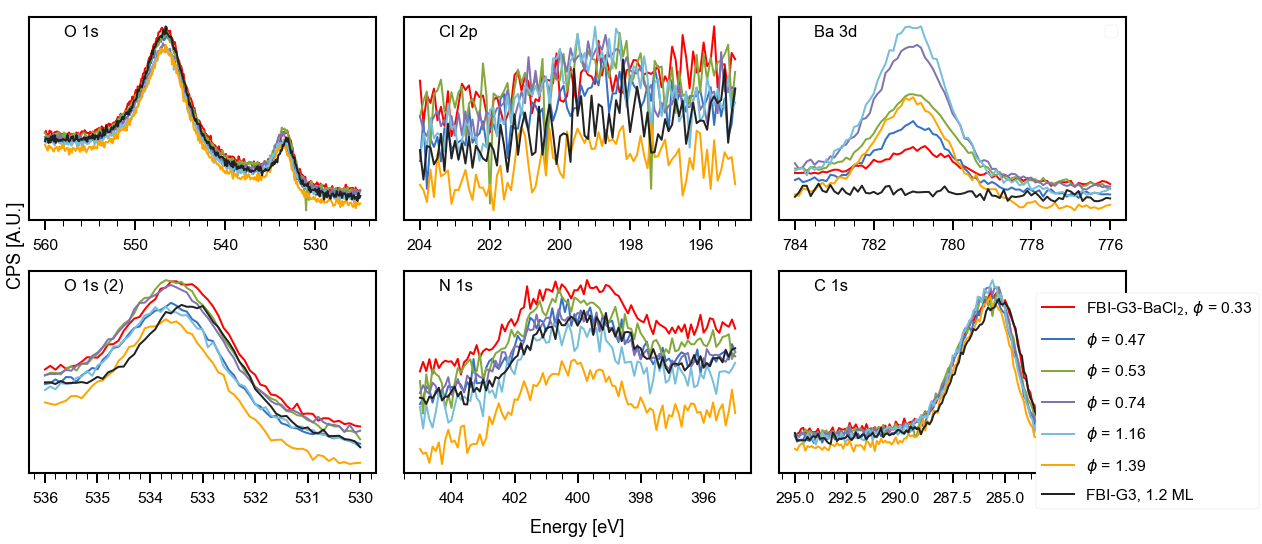

In [156]:
raw3[-1].name = 'FBI-G3, 1.2 ML'
raw3[8].name = 'FBI-G3-BaCl$_2$, $\phi$ = 0.33'
raw3[9].name = '$\phi$ = 0.47'
raw3[10].name = '$\phi$ = 0.53'
raw3[11].name = '$\phi$ = 0.74'
raw3[12].name = '$\phi$ = 1.16'
raw3[13].name = '$\phi$ = 1.39'

raw3[8].color = 'red'
raw3[9].color = 'b'
raw3[10].color = 'g'
raw3[12].color = 'c'
raw3[13].color = 'orange'

raw3[-1].color = 'k'

ax = plot_xp_regions(raw3[8:] , regs, ncols=3);


In [125]:
from matplotlib.colors import Normalize

In [157]:
[xp.name for xp in raw3]

['AuMica_FBIG3_subl_10min_3.2A',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_30min_3.5A',
 'AuMica_FBIG3_subl_15min',
 'AuMica_FBIG3_subl_15min_BaCl2_1min',
 'AuMica_clean',
 'AuMica_clean',
 'FBI-G3-BaCl$_2$, $\\phi$ = 0.33',
 '$\\phi$ = 0.47',
 '$\\phi$ = 0.53',
 '$\\phi$ = 0.74',
 '$\\phi$ = 1.16',
 '$\\phi$ = 1.39',
 'FBI-G3, 1.2 ML']

(-0.3000000000000682, (533.4, 533.7))


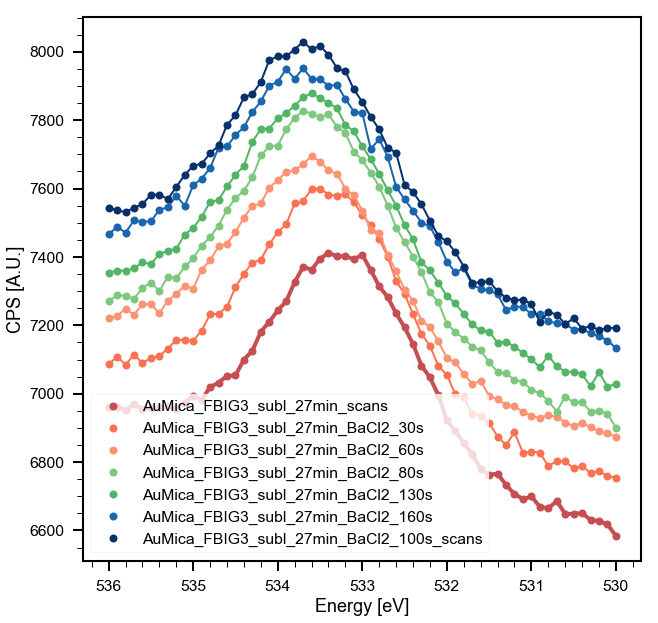

In [50]:
region = 'O_1s_(2)'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80, 90]
off = [0, 220, 220, 300, 500, 650]
scatter_region(raw3[-1], region, col='r', offset=-50)
plot_region(raw3[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw3[8:-1]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.invert_xaxis()
print(get_shift_ymax(raw3[-1], raw3[-2], region))

In [170]:
idxmax = np.argmax(raw3[-1].dfx[region].dropna().counts.values)
raw3[-1].dfx[region].energy.iloc[idxmax]

533.4

In [171]:
idxmax2 = np.argmax(raw3[-2].dfx[region].dropna().counts.values)
raw3[-2].dfx[region].energy.iloc[idxmax2]

533.7

In [12]:
raw3[-1].path

'/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/20211018_AuMica_FBIG3_subl_27min.fxy'

In [16]:
for xp in raw3[8:]:
    path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/'
    path += xp.name + '.csv'
    print(path)
    export_csv(path, xp)

/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_30s.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_60s.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_80s.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_130s.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_160s.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_BaCl2_100s_scans.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG3/2021_10_18_AuMica/proc/AuMica_FBIG3_subl_27min_scans.csv


### N 1s

In [28]:
unscaled[8].name = 'FBI-G3, 1.2 ML'
unscaled[9].name = 'FBI-G3-BaCl$_2$, $\phi$ = 0.33'
unscaled[10].name = '$\phi$ = 0.47'
unscaled[11].name = '$\phi$ = 0.53'
unscaled[12].name = '$\phi$ = 0.74'
unscaled[13].name = '$\phi$ = 1.16'
unscaled[14].name = '$\phi$ = 1.39'

In [29]:
[xp.name for xp in unscaled[7:]]

['AuMica_clean',
 'FBI-G3, 1.2 ML',
 'FBI-G3-BaCl$_2$, $\\phi$ = 0.33',
 '$\\phi$ = 0.47',
 '$\\phi$ = 0.53',
 '$\\phi$ = 0.74',
 '$\\phi$ = 1.16',
 '$\\phi$ = 1.39']

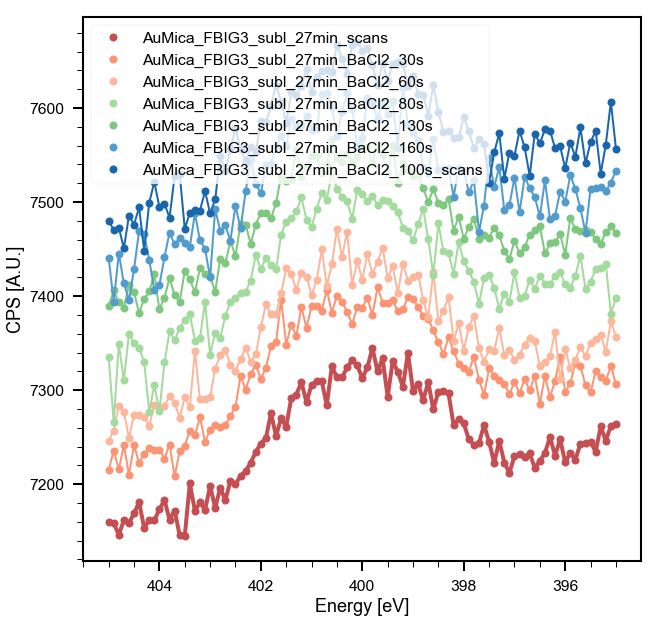

In [30]:
region = 'N_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [0, 10, 20, 30, 40, 60, 80]
off = [0, 100, 140, 220, 300, 430, 400]
scatter_region(raw3[-1], region, col='r', offset=0)
plot_region(raw3[-1], region, col='r', offset=0, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2
for i,xp in enumerate(raw3[8:-1]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    xp.color = col
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4
raw3[-1].color = 'r'

ax = plt.gca()
ax.invert_xaxis()
ax.legend(loc='upper left')

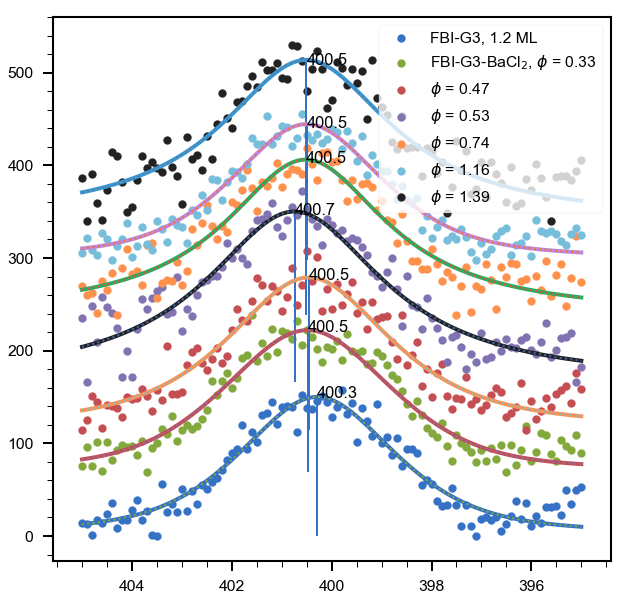

In [31]:
region = 'N_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
off = [0, 100, 150, 180, 300, 480, 400]
# scatter_region(unscaled[-1], region, col='r', offset=-50)
# plot_region(unscaled[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
# plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(unscaled[8:]):
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=False, offset=off[i]/100)
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
# ax.invert_xaxis()
ax.legend(loc='upper right')

In [32]:
raw3[-2].name
raw3[-1].name

'AuMica_FBIG3_subl_27min_scans'

In [34]:
print(get_shift_ymax(unscaled[5], unscaled[4], region))

(0.30000000000001137, (400.8, 400.5))


### C 1s

285.3 285.7 -0.39999999999997726


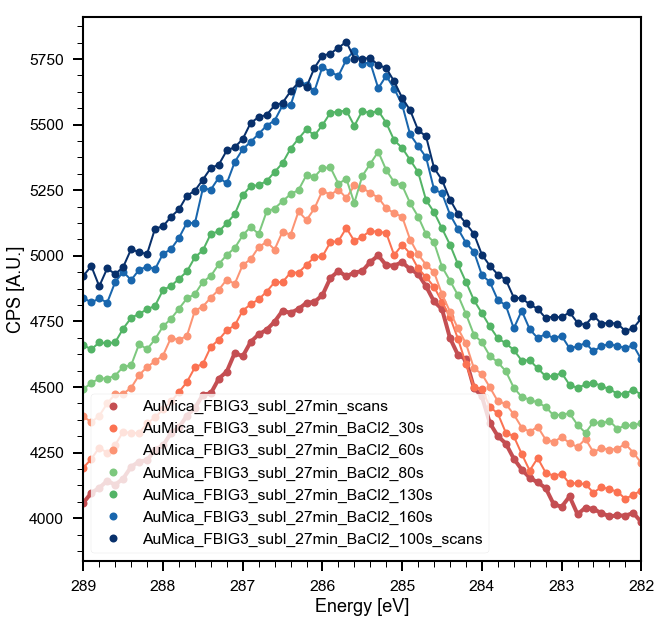

In [35]:
region = 'C_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]
off = [0, 200, 270, 420, 600, 750]
scatter_region(raw3[-1], region, col='r', offset=-50)
plot_region(raw3[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw3[8:-1]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.set(xlim=(289, 282))
idxmax = np.argmax(raw3[-1].dfx[region].dropna().counts.values)
maxreg = raw3[-1].dfx[region].energy.iloc[idxmax]

idxmax2 = np.argmax(raw3[-2].dfx[region].dropna().counts.values)
maxreg2 = raw3[-2].dfx[region].energy.iloc[idxmax2]
print(maxreg, maxreg2, maxreg-maxreg2)

In [36]:
print(get_shift_ymax(unscaled[5], unscaled[4], region))

(0.6000000000000227, (285.5, 284.9))


## Subtract clean Au 4p from O 1s

In [404]:
xp0 = gaussian_smooth(raw3[7], region, sigma = 11)
norm3 = [normalise_dfx(xp0), normalise_dfx(raw3[-1])]
for xp in raw3[8:-1]:
    norm3.append(normalise_dfx(xp))
    norm3[-1].color = xp.color
norm3[0].color= 'k'
norm3[1].color= 'r'

[Text(0, 0.5, '')]

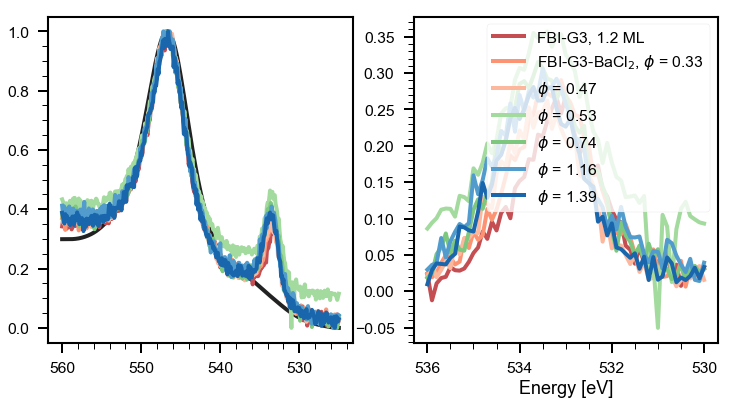

In [405]:
region = 'O_1s'
subau3 = []
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_region(norm3[0], region, ax=ax[0])
for xp in norm3[1:]:
    plot_region(xp, region, ax=ax[0])
    
    xpsub = subtract_ref_region(xp, xpRef=norm2[0], region=region)
    xpsub = crop_spectrum(xpsub, region, eup=536, edw=530)
    xpsub.color = xp.color
    subau3.append(xpsub)
    plot_region(xpsub, region, ax=ax[1])
ax[0].invert_xaxis()
ax[1].set(ylabel=None)
# plt.gca().set(xlim=(536, 530))

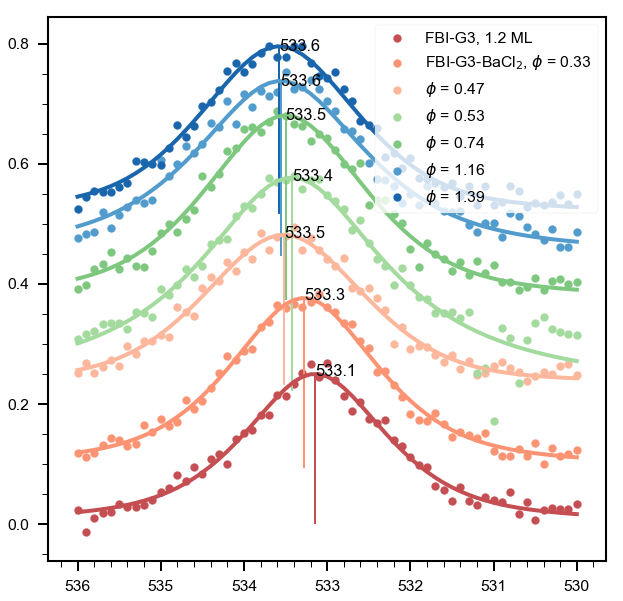

In [406]:
region = 'O_1s'
plt.figure(figsize=(10,10))
off = [0, 80, 220, 120, 280, 330, 440]

for i,xp in enumerate(subau3):
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=False, offset=off[i]/100)
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
# ax.invert_xaxis()
ax.legend(loc='upper right')

# Import data G2 

In [44]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/'
files = glob.glob(path+'/**/**/*.uxy')
files.sort()
files
files[2], files[0] = files[0], files[2]
files[2], files[1] = files[1], files[2]

In [45]:
files

['/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min_BaCl2_30s.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211105_AuMica_FBIG2_subl_20min_BaCl2_60s.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211105_AuMica_FBIG2_subl_20min_BaCl2_90s.uxy']

In [46]:
g2s = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211104_AuMica_FBIG2_subl_20min_BaCl2_30s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211105_AuMica_FBIG2_subl_20min_BaCl2_60s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211105_AuMica_FBIG2_subl_20min_BaCl2_90s.uxy.ft', returning empty fit dict


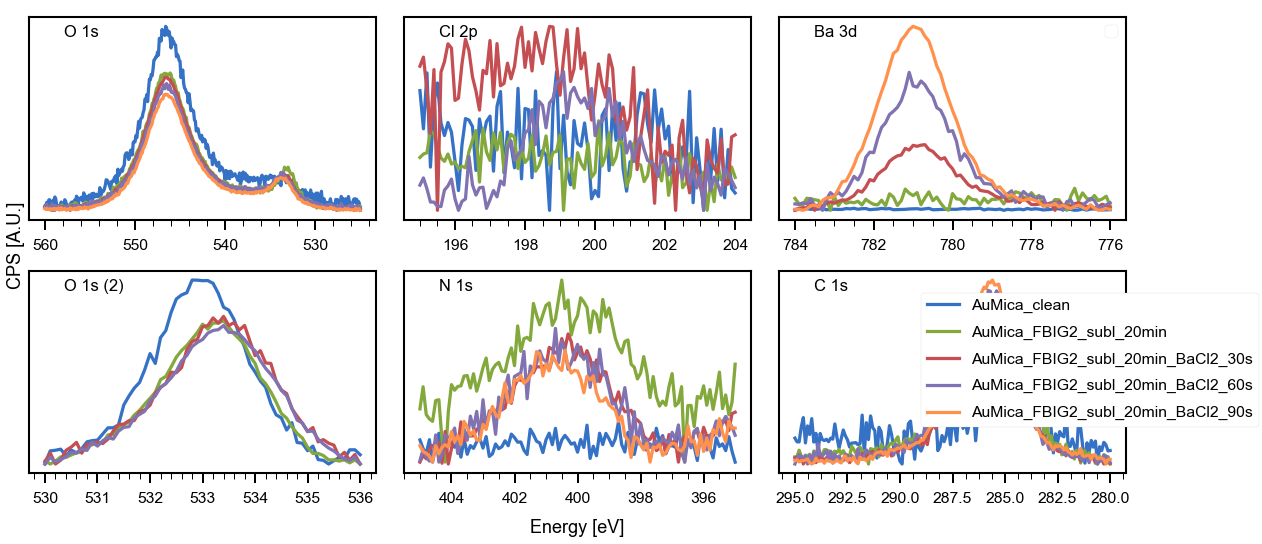

In [22]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s']
plot_xp_regions(g2s, regs);

# Stoichiometry

'Cl_2p' region does not exist in AuMica_clean
'O_1s_(2)' region does not exist in AuMica_clean


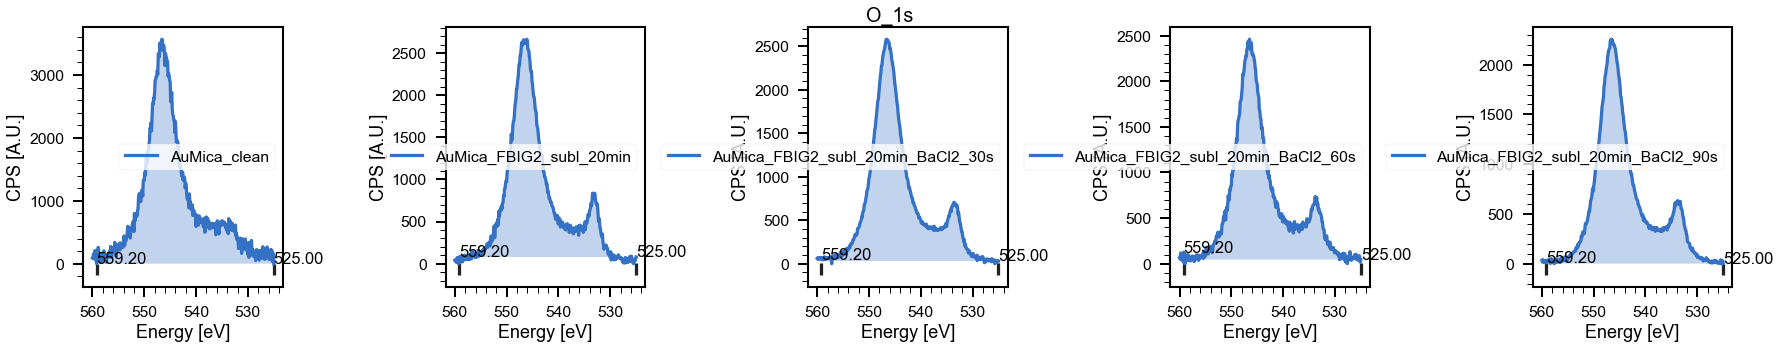

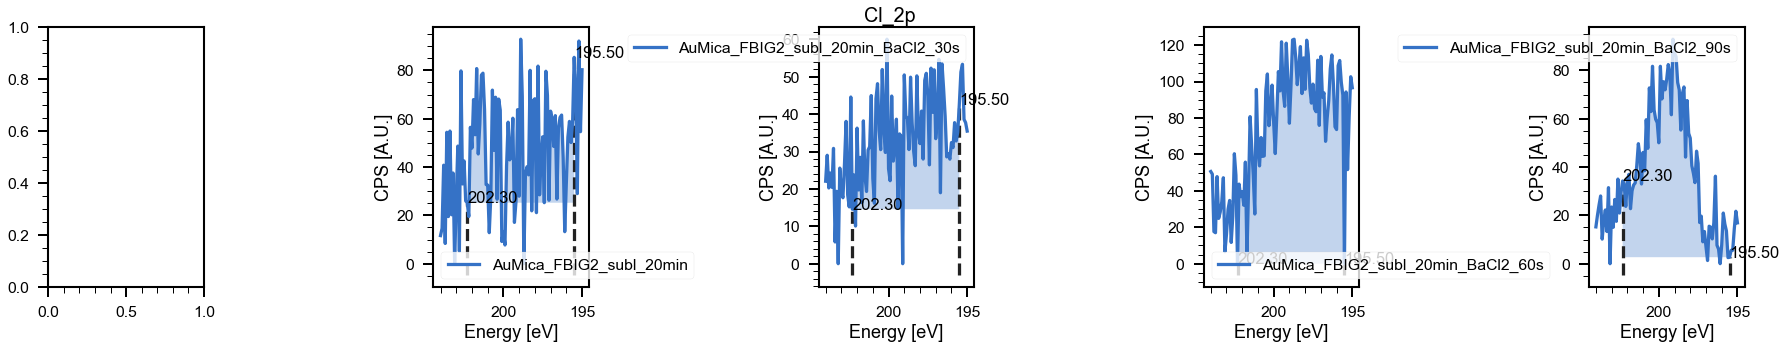

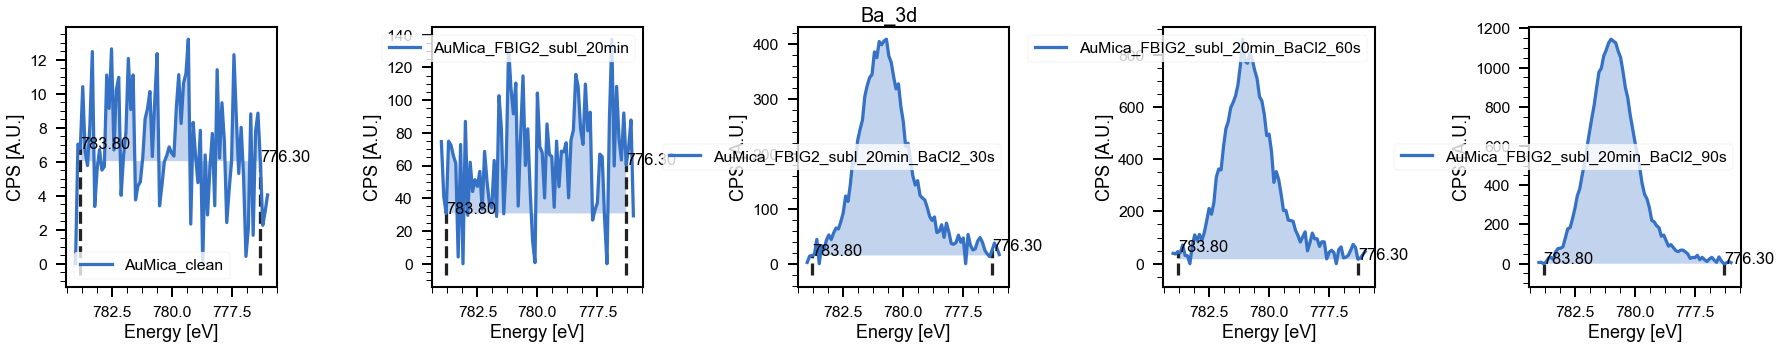

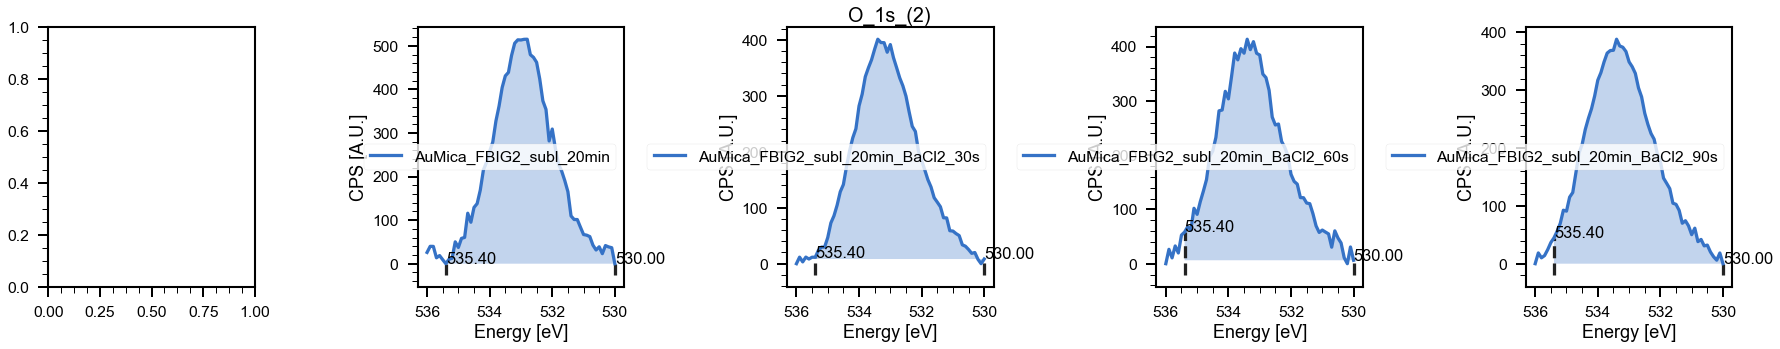

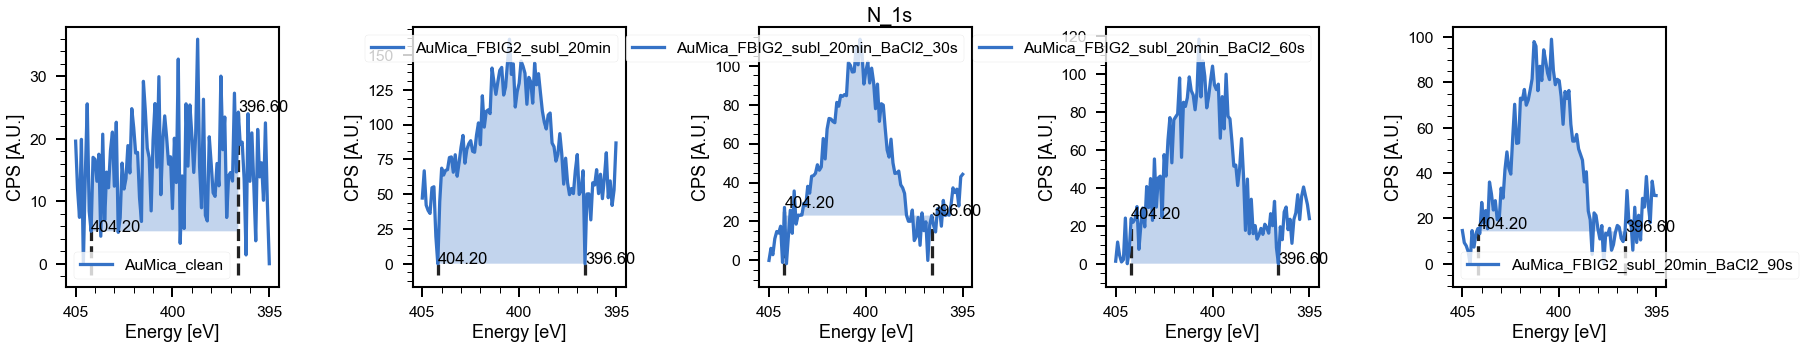

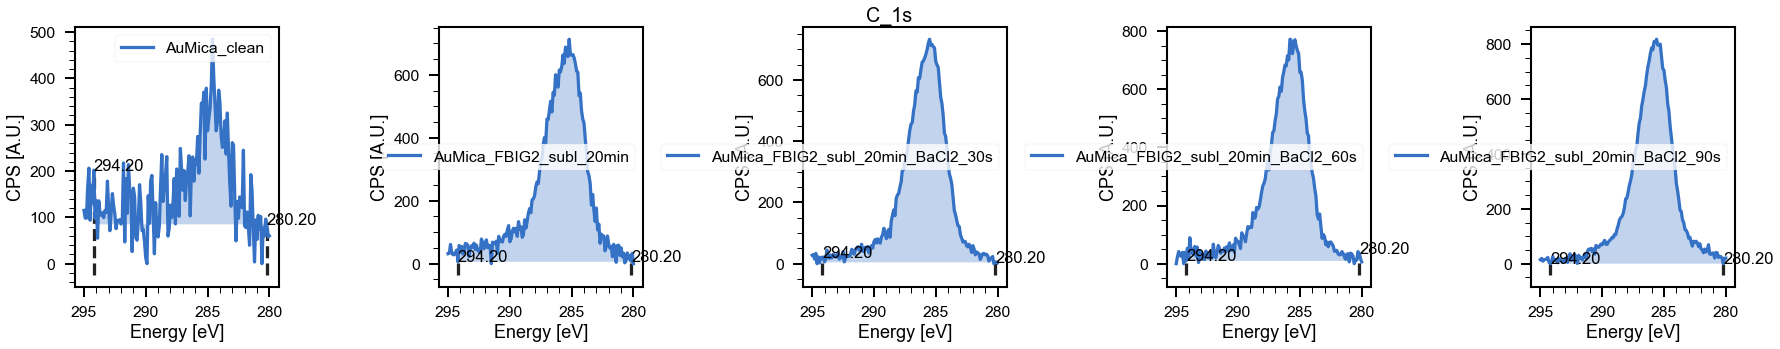

In [36]:
for r in regs:
    integrateRegions(g2s, r, asf=asf)

In [37]:
ag2sto = {'C_1s': 31, 'O_1s_(2)':5, 'N_1s':3, 'Ba_3d': 1e-10, 'Cl_2p':1e-10}
g2sto = XPS_experiment(name='Stoichiometry FBI-G2', area=ag2sto)

g2 = [g2s[i] for i in [1]]
g2ba = [g2s[j] for j in [2, 3, 4]]
for xp in g2ba:
    xp.area['FBI-g2'] = xp.area['N_1s']/3

num = ['C_1s', 'C_1s', 'O_1s_(2)', 'Ba_3d', 'Cl_2p']
denom = ['O_1s_(2)', 'N_1s', 'N_1s', 'N_1s', 'Ba_3d']
display_stoichiometry(g2 + [g2sto], num[:-2], denom[:-2])
display_stoichiometry(g2ba, num + ['Ba_3d'], denom + ['FBI-g2'])

## Coverage

In [41]:
inds = [[1, 0]]#, [3, 2], [4, 6], [7,8]]
arrange_coverages(g2s, inds, r_ml=1.1, region='Au_4f',
                  mfp=3.87, takeoff=10)

matrix([[0.49797926, 0.00267645]])

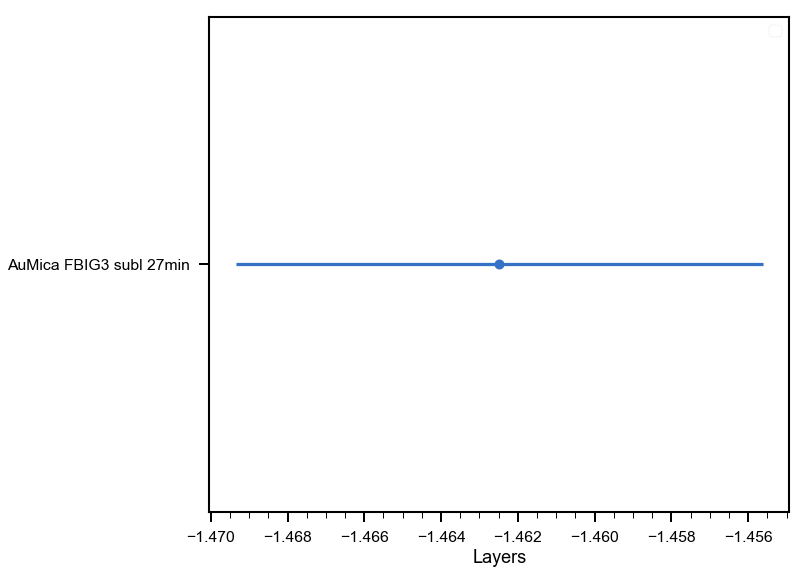

In [40]:
plot_coverages(g3)

# Compare to FBI-G1-G3

In [45]:
fileg1 = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/proc/20210510_Au111_FBI_subl_30min.uxy'
g1 = read_processed_xp(fileg1)

crop_spectrum(g1, 'O_1s', eup=536, edw=530, inplace=True);
crop_spectrum(g1, 'Au_4f', eup=95, inplace=True);


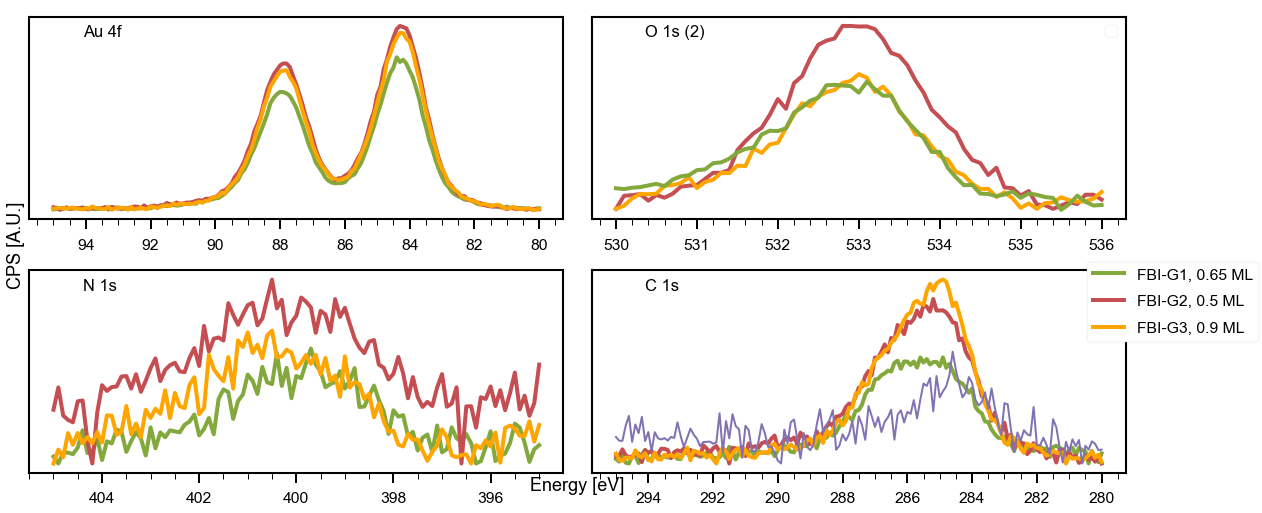

In [84]:
g3[2].color = 'orange'
g2[0].color = 'r'

g3[2].name = 'FBI-G3, 0.9 ML'
g2[0].name = 'FBI-G2, 0.5 ML'

g1.name = 'FBI-G1, 0.65 ML'

regs2 = ['Au_4f', 'O_1s_(2)', 'N_1s', 'C_1s']
ax = plot_xp_regions([g1, g2[0], g3[2]], regs2, ncols=2);
plot_region(g1, 'O_1s', ax= ax[0, 1], lb='__nolabel__')
plt.rcParams['lines.linewidth'] = 2
plot_region(g2s[0], 'C_1s', ax= ax[1, 1], lb='Au Clean (before FBI-G2)')

# Compare raw w/ and w/out Ba++

In [30]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/'

In [37]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/**'
files = glob.glob(path+'/*.xy')
files.sort()
files[2], files[0] = files[0], files[2]
files[2], files[1] = files[1], files[2]
files

['/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/20211104_AuMica_clean.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/20211104_AuMica_FBIG2_subl_20min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/20211104_AuMica_FBIG2_subl_20min_BaCl2_30s.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/20211105_AuMica_FBIG2_subl_20min_BaCl2_60s.xy',
 '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/20211105_AuMica_FBIG2_subl_20min_BaCl2_90s.xy']

In [38]:
raw2 = [xps_data_import(f) for f in files]

[xp.name for xp in raw2]
raw2[1].name = 'FBI-G2, 0.5 ML'
raw2[2].name = 'FBI-G2-BaCl$_2$, $\phi$ = 0.49'
raw2[3].name = '$\phi$ = 0.92'
raw2[4].name = '$\phi$ = 1.5'

In [39]:
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]

plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw2[1:]):
    if i < 2: xp.color = cmapr(norm(blues[-(i-2)]))
    elif i < 4: xp.color = cmapg(norm(blues[i]))

In [40]:
def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3, flag_shift: bool = False, off: list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))
    if off == None: off = [0 for i in range(len(experiments))]
    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        enmx, comx = [], [] # Peak point lists
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb, offset=off[c])
                ax[j][k].invert_xaxis()
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
            if flag_shift:
                argmx = np.argmax(xp.dfx[r].counts)
                enmx.append(xp.dfx[r].energy.loc[argmx])
                comx.append(xp.dfx[r].counts.loc[argmx])

        ax[j][k].text(s=r.replace('_', ' '), y=0.9, x=0.1, transform=ax[j][k].transAxes)
        ax[j][k].set_yticks([])
        if flag_shift:  ax[j][k].plot(enmx, comx, '--k', lw=2.5)

        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    ax[j][k].legend().remove()

    plt.xlabel('\n\nEnergy [eV]', ha='center')
    plt.figlegend(  ncol=1, bbox_to_anchor=(1.1, 0.45), framealpha=1., labelspacing=0.8 )
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)

    return ax

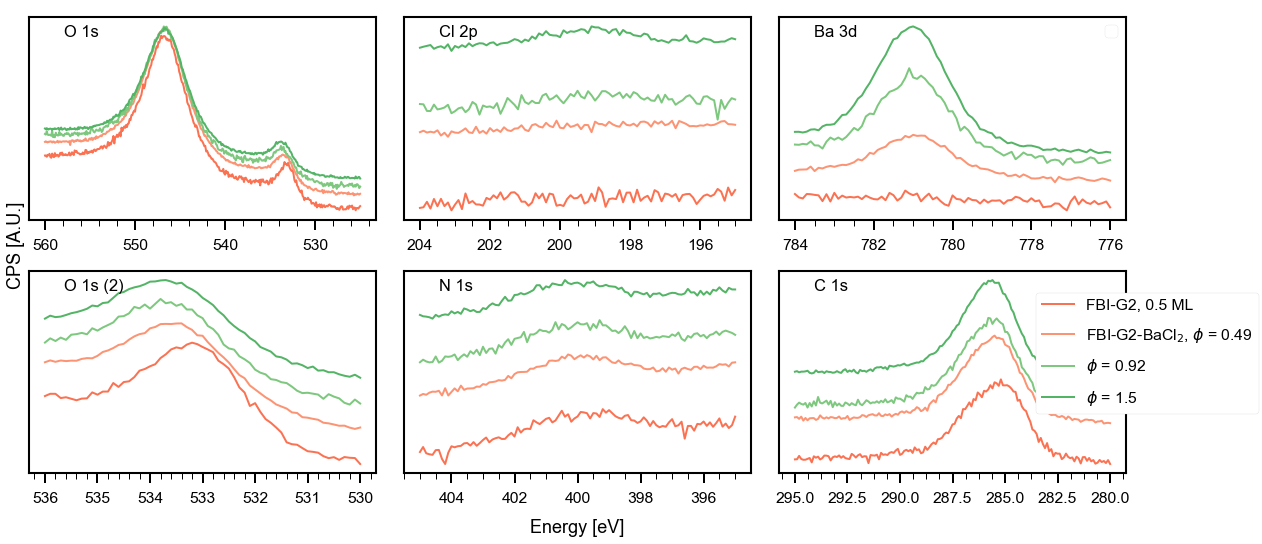

In [41]:
regs = [ 'O_1s', 'Cl_2p', 'Ba_3d', 'O_1s_(2)', 'N_1s', 'C_1s']
off = [0, 400, 500, 900, 600]

ax = plot_xp_regions(raw2[1:] , regs, ncols=3, off=off);


In [40]:
for xp in raw2[1:]:
    path = '/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/'
    path += xp.name + '.csv'
    print(path)
    export_csv(path, xp)

/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/FBI-G2, 0.5 ML.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/FBI-G2-BaCl$_2$, $\phi$ = 0.49.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/$\phi$ = 0.92.csv
/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/$\phi$ = 1.5.csv


### O 1s

(0.5, (533.7, 533.2))


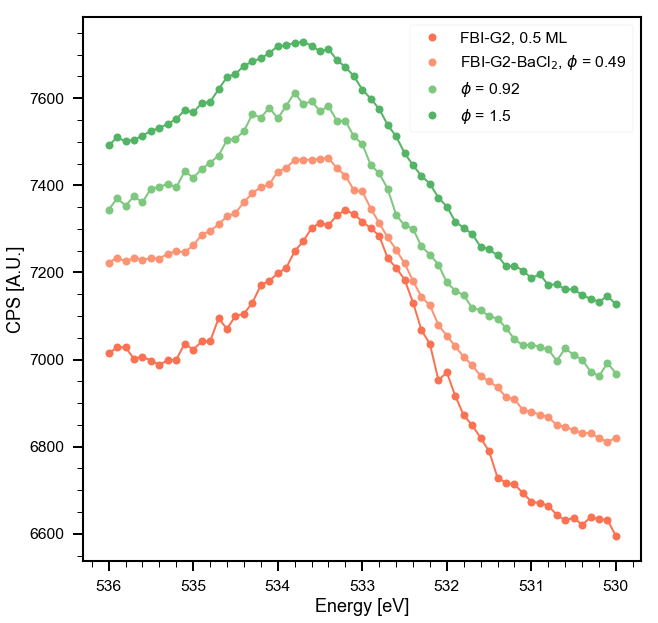

In [42]:
region = 'O_1s_(2)'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]
off = [0, 400, 500, 900, 600]
# scatter_region(raw2[-1], region, col='r', offset=-50)
# plot_region(raw2[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw2[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.invert_xaxis()
print(get_shift_ymax(raw2[4], raw2[1], region))

(0.3696159731844091, (533.3192016797135, 532.9495857065291))


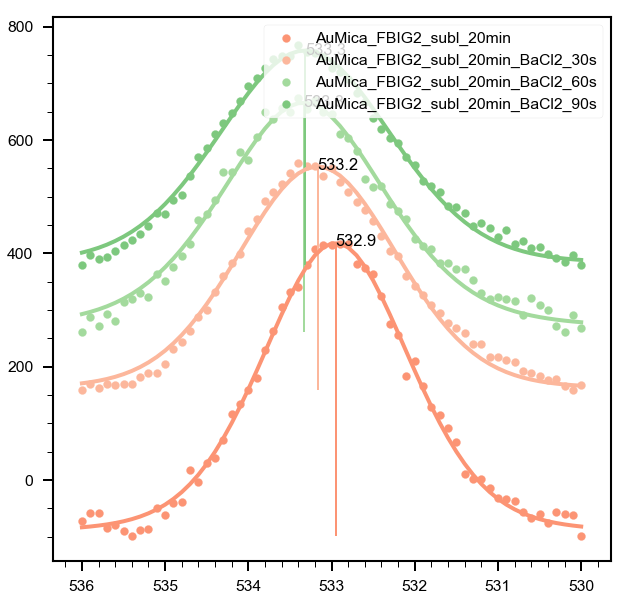

In [47]:
region = 'O_1s_(2)'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [0, 10, 20, 30, 40, 60, 80]
off = [-50, 100, 150, 230, 300, 480, 400]
# scatter_region(unscaled[-1], region, col='r', offset=-50)
# plot_region(unscaled[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
# plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(g2s[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    xp.color = col
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=False, offset=off[i]/100)
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()
ax.legend(loc='upper right')
print(get_shift_fit(g2s[4], g2s[1], region))

### N 1s

399.2 399.3 -0.10000000000002274


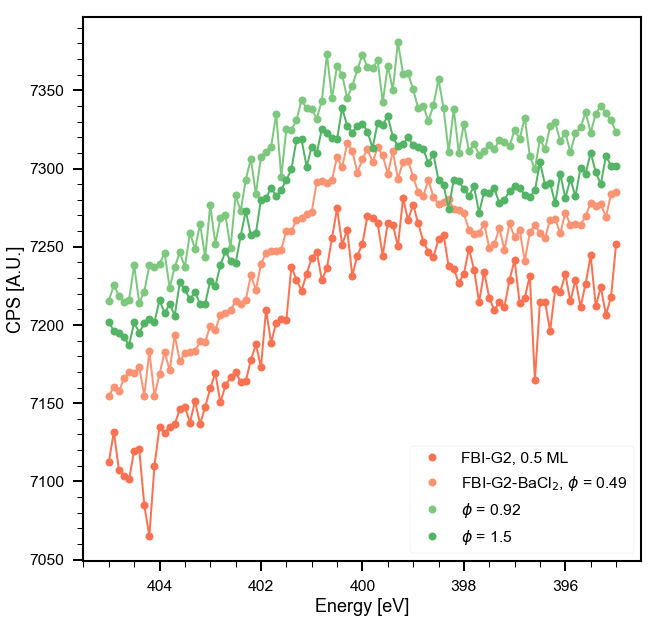

In [104]:
region = 'N_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]
off = [50, 270, 300, 500]
# scatter_region(raw2[-1], region, col='r', offset=-50)
# plot_region(raw2[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw2[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.invert_xaxis()

idxmax = np.argmax(raw2[1].dfx[region].dropna().counts.values)
maxreg = raw2[1].dfx[region].energy.iloc[idxmax]

idxmax2 = np.argmax(raw2[3].dfx[region].dropna().counts.values)
maxreg2 = raw2[3].dfx[region].energy.iloc[idxmax2]
print(maxreg, maxreg2, maxreg-maxreg2)

399.2 399.3 -0.10000000000002274


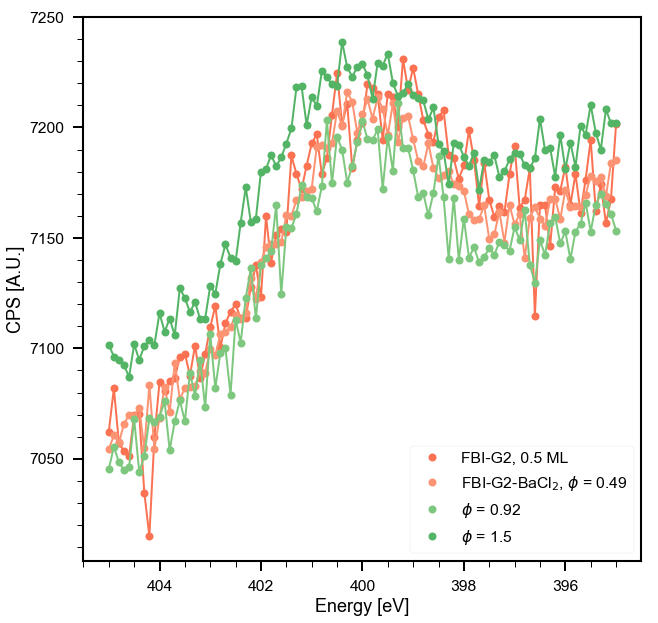

In [112]:
region = 'N_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]
off = [0, 170, 130, 400]
# scatter_region(raw2[-1], region, col='r', offset=-50)
# plot_region(raw2[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw2[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.invert_xaxis()

idxmax = np.argmax(raw2[1].dfx[region].dropna().counts.values)
maxreg = raw2[1].dfx[region].energy.iloc[idxmax]

idxmax2 = np.argmax(raw2[3].dfx[region].dropna().counts.values)
maxreg2 = raw2[3].dfx[region].energy.iloc[idxmax2]
print(maxreg, maxreg2, maxreg-maxreg2)

In [312]:
g2s[1].name = 'FBI-G2, 0.5 ML'
g2s[2].name = 'FBI-G2-BaCl$_2$, $\phi$ = 0.49'
g2s[3].name = '$\phi$ = 0.92'
g2s[4].name = '$\phi$ = 1.5'

(-0.10000000000002274, (400.4, 400.5))


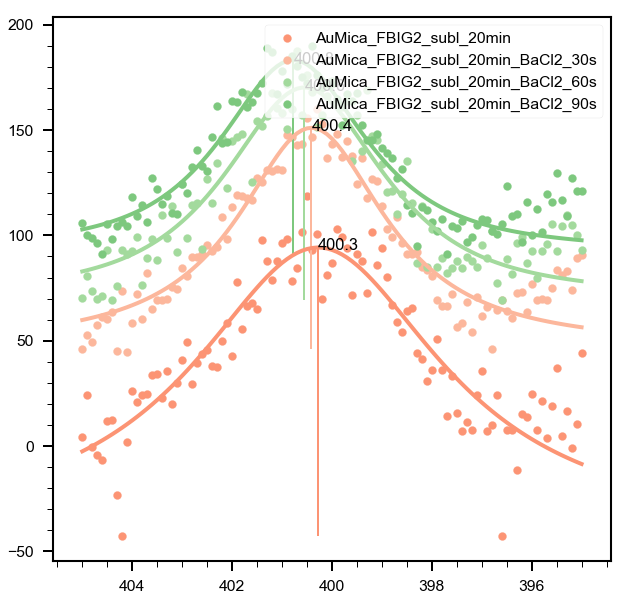

In [49]:
region = 'N_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [0, 10, 20, 30, 40, 60, 80]
off = [-50, 100, 150, 230, 300, 480, 400]
# scatter_region(unscaled[-1], region, col='r', offset=-50)
# plot_region(unscaled[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
# plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(g2s[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    xp.color = col
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=False, offset=off[i]/100)
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()
ax.legend(loc='upper right')
print(get_shift_ymax(g2s[4], g2s[1], region))

### C 1s

(0.4000000000000341, (285.6, 285.2))


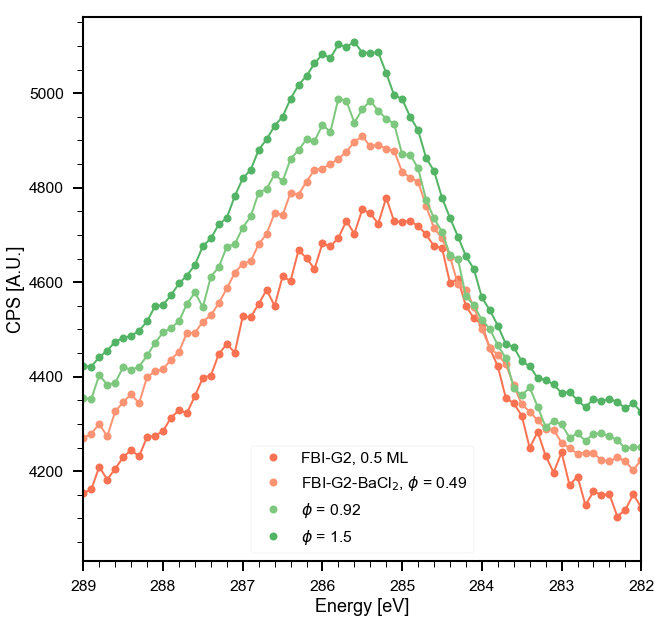

In [252]:
region = 'C_1s'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 8

plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [10, 20, 30, 40, 60, 80]
off = [110, 270, 300, 500]
# scatter_region(raw2[-1], region, col='r', offset=-50)
# plot_region(raw2[-1], region, col='r', offset=-50, lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 2

for i,xp in enumerate(raw2[1:]):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    scatter_region(xp, region, col=col, offset=off[i])
    plot_region(xp, region, col=col, offset=off[i], lb='__nolabel__');#'$\\Phi$ = %.2f'%fbibaratio[i])
plt.rcParams['lines.linewidth'] = 4


ax = plt.gca()
ax.invert_xaxis()
ax.set(xlim=(289, 282))
print(get_shift_ymax(raw2[4], raw2[1], region))

(0.3696159731844091, (533.3192016797135, 532.9495857065291))
(0.5, (533.7, 533.2))


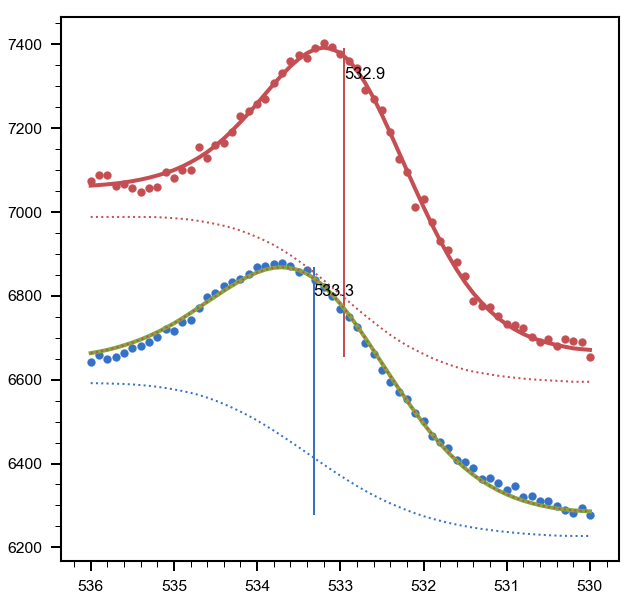

In [264]:
region = 'O_1s_(2)'
plt.figure(figsize=(10,10))

for xp in [g2s[1],g2s[4]]:
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=True)
    
plt.gca().invert_xaxis()
print(get_shift_fit(g2s[4], g2s[1], region))
print(get_shift_ymax(raw2[4], raw2[1], region))

Modify user pars
Modify user pars
(0.0, (284.8, 284.8))


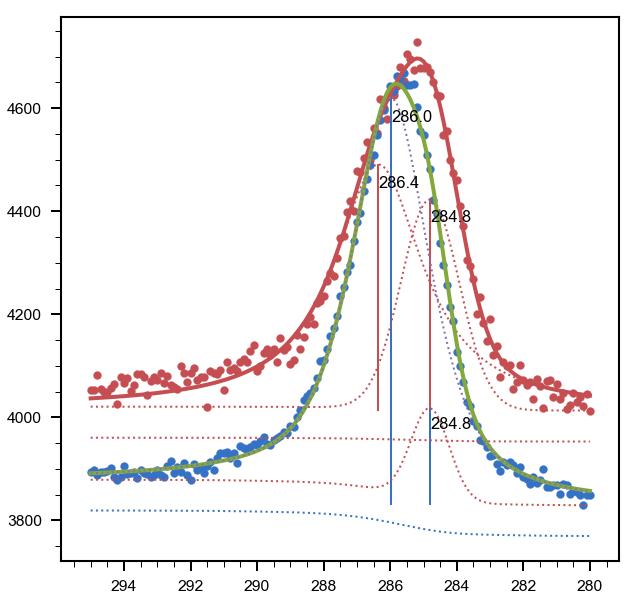

In [259]:
region = 'C_1s'
plt.figure(figsize=(10,10))

for xp in [g2s[1],g2s[4]]:
    xf0 = XPFit(xp, region)
    xf0.preset_pars('v1_center',284.8)
    xf0.double_voigt(286)
    plot_fit_result(xp, region, plot_bg=True)
plt.gca().invert_xaxis()
print(get_shift_fit(g2s[4], g2s[1], region))

(0.4954238795535275, (400.77279604588756, 400.27737216633403))


<Figure size 720x720 with 0 Axes>

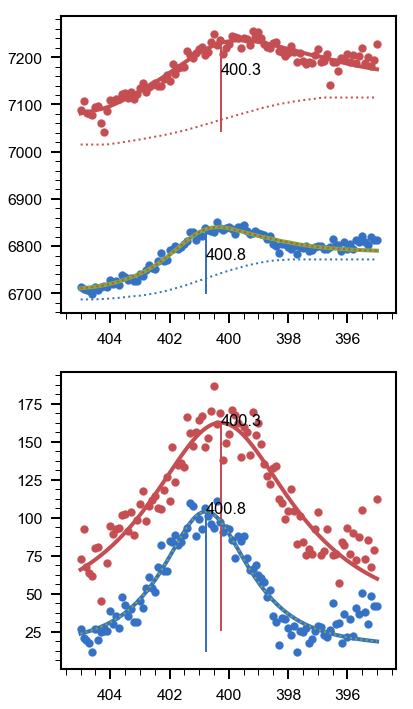

In [240]:
region = 'N_1s'
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
for xp in [g2s[1],g2s[4]]:
    XPFit(xp, region).voigt()
    plot_fit_result(xp, region, plot_bg=True, ax=ax[0])
    plot_fit_result(xp, region, plot_bg=False, ax=ax[1])
    
for a in ax:
    a.invert_xaxis()
print(get_shift_fit(g2s[4], g2s[1], region))

## Subtract clean Au 4p from O 1s

In [330]:
xp0 = gaussian_smooth(raw2[0], region, sigma = 11)
norm2 = [normalise_dfx(xp0)]
for xp in raw2[1:]:
    norm2.append(normalise_dfx(xp))

[Text(0, 0.5, '')]

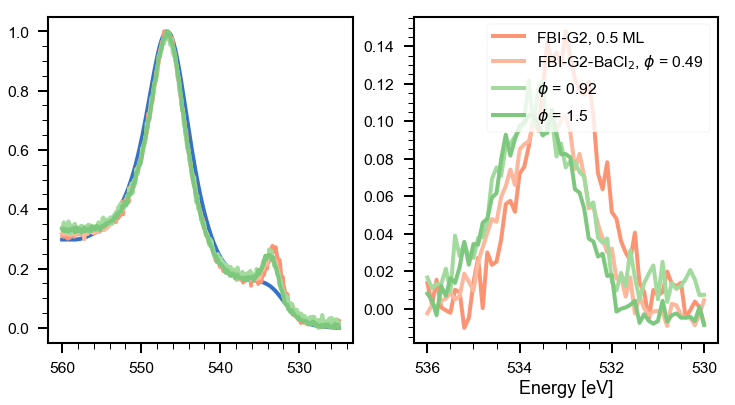

In [342]:
region = 'O_1s'
subau2 = []
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_region(norm2[0], region, ax=ax[0])
for xp in norm2[1:]:
    plot_region(xp, region, ax=ax[0])
    
    xpsub = subtract_ref_region(xp, xpRef=norm2[0], region=region)
    xpsub = crop_spectrum(xpsub, region, eup=536, edw=530)
    subau2.append(xpsub)
    plot_region(xpsub, region, ax=ax[1])
ax[0].invert_xaxis()
ax[1].set(ylabel=None)
# plt.gca().set(xlim=(536, 530))

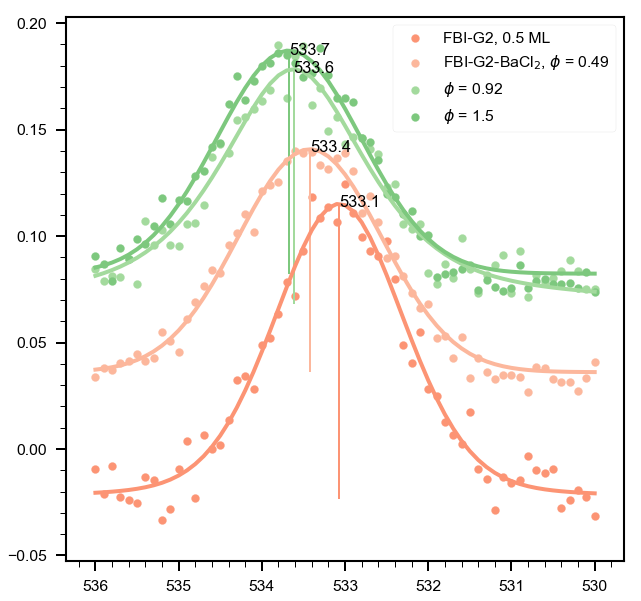

In [349]:
region = 'O_1s'
plt.figure(figsize=(10,10))
cmap = plt.cm.Blues
cmapr = plt.cm.Reds
cmapg = plt.cm.Greens

norm = Normalize(vmin=-15, vmax=80)
blues = [0, 10, 20, 30, 40, 60, 80]
off = [-50, 100, 150, 230, 300, 480, 400]

for i,xp in enumerate(subau2):
    if i < 2: col = cmapr(norm(blues[-(i-2)]))
    elif i < 4: col = cmapg(norm(blues[i]))
    
    else: col = cmap(norm(blues[i]))
    xp.color = col
    XPFit(xp, region).voigt()
#     plot_region(xp, region)
    plot_fit_result(xp, region, plot_bg=False, offset=off[i]/100)
plt.rcParams['lines.linewidth'] = 4

ax = plt.gca()
ax.invert_xaxis()
ax.legend(loc='upper right')

# Compare to BaCl2 alone

In [7]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files[0], files[2] = files[2], files[0]
files
samp4 = [read_processed_xp(f) for f in files]


[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/proc/20210525_Au111_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/proc/20210525_Au111_BaCl2_subl_80s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/proc/20210525_Au111_BaCl2_subl_320s.uxy.ft', returning empty fit dict


In [150]:
[xp.name for xp in unscaled]

['AuMica_FBIG3_subl_10min_3.2A',
 'AuMica_clean',
 'AuMica_clean',
 'AuMica_FBIG3_subl_30min_3.5A',
 'AuMica_FBIG3_subl_15min',
 'AuMica_FBIG3_subl_15min_BaCl2_1min',
 'AuMica_clean',
 'AuMica_FBIG3_subl_27min',
 'AuMica_clean',
 'AuMica_FBIG3_subl_27min_BaCl2_30s',
 'AuMica_FBIG3_subl_27min_BaCl2_60s',
 'AuMica_FBIG3_subl_27min_BaCl2_80s',
 'AuMica_FBIG3_subl_27min_BaCl2_130s',
 'AuMica_FBIG3_subl_27min_BaCl2_100s',
 'AuMica_FBIG3_subl_27min_BaCl2_160s']

[[], Text(0, 0.5, ''), Text(0.5, 0, '')]

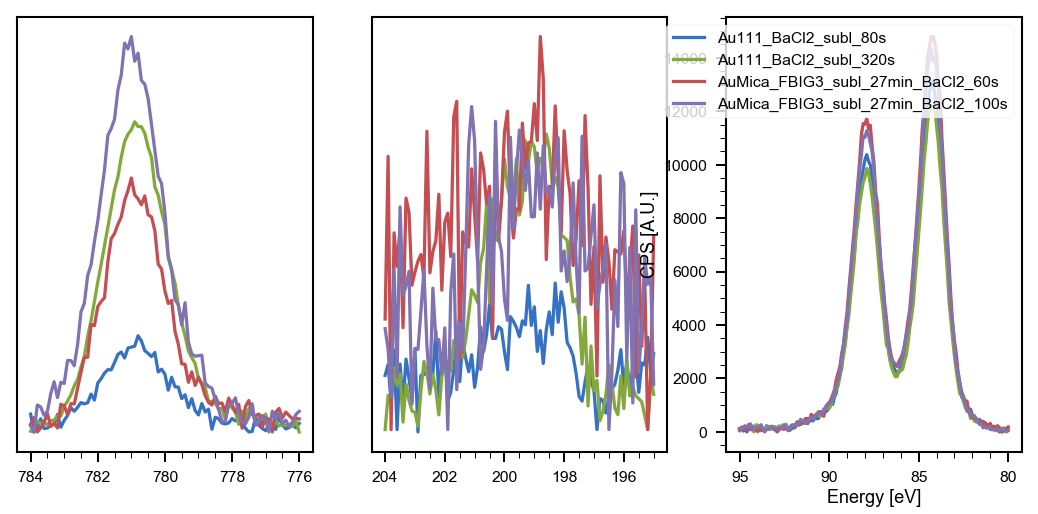

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))
samp4[2].color= 'g'

plot_region(samp4[1], 'Cl_2p', ax=ax[1])
plot_region(samp4[1], 'Ba_3d', ax=ax[0])
plot_region(samp4[1], 'Au_4f', ax=ax[2])

plot_region(samp4[2], 'Cl_2p', ax=ax[1])
plot_region(samp4[2], 'Ba_3d', ax=ax[0])
plot_region(samp4[2], 'Au_4f', ax=ax[2])

plot_region(unscaled[10], 'Cl_2p', ax=ax[1])
plot_region(unscaled[10], 'Ba_3d', ax=ax[0])
plot_region(unscaled[10], 'Au_4f', ax=ax[2])

plot_region(unscaled[11], 'Cl_2p', ax=ax[1])
plot_region(unscaled[11], 'Ba_3d', ax=ax[0])
plot_region(unscaled[11], 'Au_4f', ax=ax[2])

ax[0].set(yticks=[])
ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[2].invert_xaxis()
ax[1].set(yticks=[], xlabel=None, ylabel=None)#, ylim=ax[0].get_ylim())
# ax[1].get_legend().remove()

[[], Text(0, 0.5, ''), Text(0.5, 0, '')]

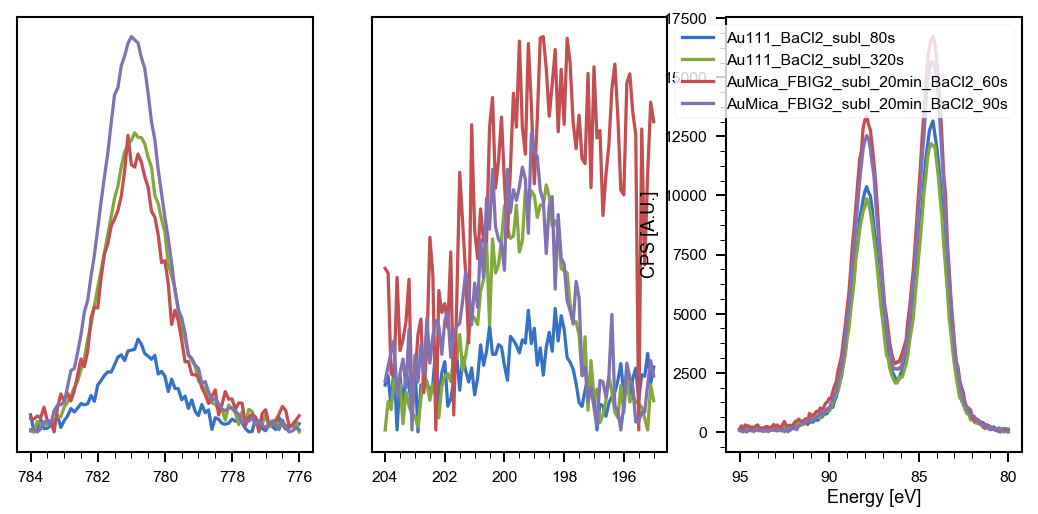

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18, 8))
samp4[2].color= 'g'

plot_region(samp4[1], 'Cl_2p', ax=ax[1])
plot_region(samp4[1], 'Ba_3d', ax=ax[0])
plot_region(samp4[1], 'Au_4f', ax=ax[2])

plot_region(samp4[2], 'Cl_2p', ax=ax[1])
plot_region(samp4[2], 'Ba_3d', ax=ax[0])
plot_region(samp4[2], 'Au_4f', ax=ax[2])

plot_region(g2s[3], 'Cl_2p', ax=ax[1])
plot_region(g2s[3], 'Ba_3d', ax=ax[0])
plot_region(g2s[3], 'Au_4f', ax=ax[2])

plot_region(g2s[4], 'Cl_2p', ax=ax[1])
plot_region(g2s[4], 'Ba_3d', ax=ax[0])
plot_region(g2s[4], 'Au_4f', ax=ax[2])

ax[0].set(yticks=[])
ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[2].invert_xaxis()
ax[1].set(yticks=[], xlabel=None, ylabel=None)#, ylim=ax[0].get_ylim())
# ax[1].get_legend().remove()

In [20]:
g2s[3].path

'/Users/pabloherrero/sabat/xps_spectra/Au_mica_FBIG2/2021_11_04_AuMica/proc/20211105_AuMica_FBIG2_subl_20min_BaCl2_60s.uxy'

In [47]:
def export_csv(file: str, xp: XPS_experiment):
    """Export to Igor compatible csv format"""
    with open(file, 'w') as fout:
        regions = [xp.dfx.columns[r][0] for r in range(len(xp.dfx.columns))]
        header = ''.join('%s_BE\t%s_cps\t' %(r, r) for r in regions[::2])
        fout.write(header+'\n')
        xp.dfx.to_csv(fout, sep='\t', na_rep='NaN', index=None, header=False)


In [48]:
exp = [g2s[3], g2s[4], samp4[1], samp4[2], unscaled[10], unscaled[11]]
path = '/Users/pabloherrero/sabat/xps_spectra/ALOISA/BaCl2/'
for xp in exp:
    export_csv(path+xp.name+'.csv', xp)